# Проект: Линейные модели в машинном обучении

### Введение

В современном сельском хозяйстве принятие обоснованных решений при выборе животных для расширения поголовья становится всё более критичным фактором успеха фермерских хозяйств. Молочное животноводство особенно чувствительно к качеству селекции, поскольку характеристики каждой коровы напрямую влияют на экономические показатели хозяйства.

#### Проблема

Молочное хозяйство "Вольный луг" планирует расширение поголовья через приобретение новых коров у ассоциации пастбищ "ЭкоФерма". Ключевая проблема заключается в необходимости объективной оценки потенциальных приобретений по двум критическим параметрам:
- Продуктивность (годовой удой)
- Качество молока (вкусовые характеристики)

Существующие методы отбора часто подвержены субъективным факторам и потенциальному приукрашиванию данных со стороны продавцов, что создает риски при инвестировании в расширение стада.

#### Цель

Разработать систему поддержки принятия решений на основе машинного обучения, которая позволит:
- Прогнозировать годовой удой потенциальных приобретений
- Оценивать вероятность получения высококачественного молока с желаемыми вкусовыми характеристиками

Автоматизировать процесс отбора коров в соответствии с установленными критериями:
- Минимальный годовой удой: 6000 кг
- Соответствие стандартам вкусовых качеств молока

#### План

1. Загрузка данных
2. Первичный осмотр данных
3. Предобработка данных
    - Проверка и обработка пропусков
    - Поиск и устранение дубликатов
    - Проверка и коррекция типов данных
    - Переименование столбцов при необходимости
    - Промежуточный вывод
4. Исследовательский анализ
    - Статистический анализ признаков
    - Визуализация распределений
    - Анализ распределений
    - Выявление выбросов
    - Промежуточный вывод
5. Корреляционный анализ
    - Изучиние взаимосвязи между признаками
    - Рассчет коэффициентов корреляции
    - Диаграмы рассеяния
    - Анализ нелинейных связей
    - Проверка мультиколлинеарности
    - Промежуточный вывод
6. Обучение модели линейной регрессии
    - Подготовка данных
    - Обучение
    - Оценка качества
    - Анализ остатков
    - Промежуточный вывод
7. Обучение модели логистической регрессии
    - Подготовка данных
    - Обучение
    - Оценка метрик
    - Построение матрицы ошибок
    - Настройка порога классификации
    - Прогноз для новых коров
8. Итоговые выводы
    - Объединение результатов
    - Отбор коров
    - Формирование рекомендаций
    - Анализ возможных улучшений

## Загрузка данных

### Импорты библиотек

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

### Загрузка датасетов

In [2]:
pd.options.display.float_format = '{:,.2f}'.format

def load_dataset(
        filename,
        sep = ';',
        decimal = ',',
        base_url='https://code.s3.yandex.net/datasets/'
):
    try:
        df = pd.read_csv(filename, sep=sep, decimal=decimal)
        print(f'Датасет {filename} загружен локально')
    except FileNotFoundError:
        df = pd.read_csv(base_url + filename, sep=sep, decimal=decimal)
        print(f'Датасет {filename} загружен удаленно')
    return df

ferma_main = load_dataset('ferma_main.csv')
ferma_dad = load_dataset('ferma_dad.csv')
cow_buy = load_dataset('cow_buy.csv')

Датасет ferma_main.csv загружен удаленно
Датасет ferma_dad.csv загружен удаленно
Датасет cow_buy.csv загружен удаленно


### Настройки графиков

In [3]:
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

##  Предобработка данных

In [4]:
class DataFrameInfo:
    def __init__(self, df, name='DataFrame'):
        self.df = df
        self.name = name
        
    def display(self):
        print(f'\n{"="*50}')
        print(f'Датасет: {self.name}')
        print(f'{"="*50}\n')
        
        print('Первые 5 строк:')
        display(self.df.head())
        
        print('\nОбщая информация:')
        print(f'Размер: строк: {self.df.shape[0]}, колонок: {self.df.shape[1]}.')
        
        print('\nТипы данных:')
        for col, dtype in self.df.dtypes.items():
            print(f'{col}: {dtype}')
            
        missing = self.df.isnull().sum()
        if missing.any():
            print(f'\nПропущенные значения: {missing[missing > 0]}')
        else:
            print('\nПропущенных значений нет.')
        
        duplicates = self.df.duplicated().sum()
        print(f'\nКоличество дубликатов: {duplicates}')
        dupl = int(duplicates)
        if dupl > 0:
            print(f'Процент дубликатов: {round((dupl/len(self.df))*100, 2)}%')

### Датафрейм ferma_main
#### Описание данных:
- id — уникальный идентификатор коровы.
- Удой, кг — масса молока, которую корова даёт в год (в килограммах).
- ЭКЕ (Энергетическая кормовая единица) — показатель питательности корма коровы.
- Сырой протеин, г — содержание сырого протеина в корме (в граммах).
- СПО (Сахаро-протеиновое соотношение) — отношение сахара к протеину в корме коровы.
- Порода — порода коровы.
- Тип пастбища — ландшафт лугов, на которых паслась корова.
- порода папы_быка — порода папы коровы.
- Жирность,% — содержание жиров в молоке (в процентах).
- Белок,% — содержание белков в молоке (в процентах).
- Вкус молока — оценка вкуса по личным критериям фермера, бинарный признак (вкусно, не вкусно).
- Возраст — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).


In [5]:
info_main = DataFrameInfo(ferma_main, 'ferma_main')
info_main.display()


Датасет: ferma_main

Первые 5 строк:


id  Удой, кг  ЭКЕ (Энергетическая кормовая единица)  Сырой протеин, г  \
0   1      5863                                  14.20              1743   
1   2      5529                                  12.80              2138   
2   3      5810                                  14.00              1854   
3   4      5895                                  12.40              2012   
4   5      5302                                  12.80              1675   

   СПО (Сахаро-протеиновое соотношение)           Порода Тип пастбища  \
0                                  0.89   Вис Бик Айдиал    Равнинное   
1                                  0.89   Вис Бик Айдиал    Равнинные   
2                                  0.89  РефлешнСоверинг    Холмистое   
3                                  0.89  РефлешнСоверинг    Холмистое   
4                                  0.89   Вис Бик Айдиал    Равнинные   

  порода папы_быка  Жирность,%  Белок,% Вкус молока      Возраст  
0           Айдиал        3.58     3.08      вкусно  более_2_лет  
1          Соверин        3.54     3.08      вкусно  менее_2_лет  
2          Соверин        3.59     3.07   не вкусно  более_2_лет  
3           Айдиал        3.40     3.08   не вкусно  более_2_лет  
4          Соверин        3.73     3.07      вкусно  менее_2_лет


Общая информация:
Размер: строк: 634, колонок: 12.

Типы данных:
id: int64
Удой, кг: int64
ЭКЕ (Энергетическая кормовая единица): float64
Сырой протеин, г: int64
СПО (Сахаро-протеиновое соотношение): float64
Порода: object
Тип пастбища: object
порода папы_быка: object
Жирность,%: float64
Белок,%: float64
Вкус молока: object
Возраст: object

Пропущенных значений нет.

Количество дубликатов: 5
Процент дубликатов: 0.79%


#### Первичный анализ
- Пропуски отсутсвуют.
- Обнаружены дубликаты, их немного, нужно удалить.
- Столбцы нужно переименовать.
- Проанализировать категориальные признаки.
- Типы данных в порядке.

#### Удаление дубликатов

In [6]:
def custom_drop_duplicates(df):
    len_before_drop = len(df)
    #df = df.drop_duplicates().reset_index(drop=True)
    df = df.drop_duplicates() # пришел к выводу что индексы удалять нельзя
    a, b = len_before_drop, len(df)
    print(a, b, round((a-b)/a*100, 2), '% данных удалено.')
    return df

In [7]:
ferma_main = custom_drop_duplicates(ferma_main)

634 629 0.79 % данных удалено.


#### Переименование столбцов

In [8]:
def rename_columns(df):
    df.columns = df.columns.str.replace('%', '')
    df.columns = df.columns.str.replace(',', '')

    rename_dict = {
        'Удой кг': 'удой',
        'ЭКЕ (Энергетическая кормовая единица)': 'эке',
        'Сырой протеин г': 'протеин',
        'СПО (Сахаро-протеиновое соотношение)': 'спо',
        'Порода': 'порода',
        'Тип пастбища': 'пастбище',
        'порода папы_быка': 'порода_отца',
        'Имя_папы': 'имя_отца',
        'Имя Папы': 'имя_отца',
        'Текущая_жирность': 'жирность',
        'Жирность': 'жирность',
        'Белок': 'белок',
        'Текущий_уровень_белок': 'белок',
        'Возраст': 'возраст',
        'Вкус молока': 'вкус'
    }
    
    existing_columns = {
        col: new_name for col, new_name in rename_dict.items() if col in df.columns
    }
    
    df = df.rename(columns=existing_columns)
    
    return df

In [9]:
ferma_main = rename_columns(ferma_main)
ferma_main.head()

id  удой   эке  протеин  спо           порода   пастбище порода_отца  \
0   1  5863 14.20     1743 0.89   Вис Бик Айдиал  Равнинное      Айдиал   
1   2  5529 12.80     2138 0.89   Вис Бик Айдиал  Равнинные     Соверин   
2   3  5810 14.00     1854 0.89  РефлешнСоверинг  Холмистое     Соверин   
3   4  5895 12.40     2012 0.89  РефлешнСоверинг  Холмистое      Айдиал   
4   5  5302 12.80     1675 0.89   Вис Бик Айдиал  Равнинные     Соверин   

   жирность  белок       вкус      возраст  
0      3.58   3.08     вкусно  более_2_лет  
1      3.54   3.08     вкусно  менее_2_лет  
2      3.59   3.07  не вкусно  более_2_лет  
3      3.40   3.08  не вкусно  более_2_лет  
4      3.73   3.07     вкусно  менее_2_лет

#### Категориальные признаки

In [10]:
def show_categorical_unique(df):
    categorical_columns = df.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        print(df[col].unique())

In [11]:
show_categorical_unique(ferma_main)

['Вис Бик Айдиал' 'РефлешнСоверинг']
['Равнинное' 'Равнинные' 'Холмистое']
['Айдиал' 'Соверин' 'Айдиалл']
['вкусно' 'не вкусно']
['более_2_лет' 'менее_2_лет']


#### Неявные дубликаты!

In [12]:
ferma_main['пастбище'] = ferma_main['пастбище'].replace('Равнинные', 'Равнинное')
ferma_main['порода_отца'] = ferma_main['порода_отца'].replace('Айдиалл', 'Айдиал')

show_categorical_unique(ferma_main)

['Вис Бик Айдиал' 'РефлешнСоверинг']
['Равнинное' 'Холмистое']
['Айдиал' 'Соверин']
['вкусно' 'не вкусно']
['более_2_лет' 'менее_2_лет']


#### Вывод
- Обнаружены и удалены явные дубликаты
- Обнаружены и исправлены не явные дубликаты в категориальных признаках
- Переименованы столбцы

### Датафрейм ferma_dad
#### Описание данных
- id — уникальный идентификатор коровы.
- Имя Папы — имя папы коровы.

In [13]:
info_dad = DataFrameInfo(ferma_dad, 'ferma_dad')
info_dad.display()


Датасет: ferma_dad

Первые 5 строк:


id  Имя Папы
0   1    Буйный
1   2  Соловчик
2   3     Барин
3   4    Буйный
4   5     Барин


Общая информация:
Размер: строк: 629, колонок: 2.

Типы данных:
id: int64
Имя Папы: object

Пропущенных значений нет.

Количество дубликатов: 0


#### Первичный анализ
- Пропуски отсутствуют.
- Дубликаты отсутствуют.
- Столбец переименовать.
- Проанализировать категориальные признаки.
- Типы данных в порядке.

#### Переименование столбцов

In [14]:
ferma_dad = rename_columns(ferma_dad)
ferma_dad.head()

id  имя_отца
0   1    Буйный
1   2  Соловчик
2   3     Барин
3   4    Буйный
4   5     Барин

#### Категориальные признаки

In [15]:
show_categorical_unique(ferma_dad)

['Буйный' 'Соловчик' 'Барин' 'Геркулес']


#### Вывод
- Дубликаты явные или не явные не обнаружены.
- Столбцы переименованы.

### Датафрейм cow_buy
#### Описание данных
- Порода — порода коровы.
- Тип пастбища — ландшафт лугов, на которых паслась корова.
- порода папы_быка — порода папы коровы.
- Имя_папы — имя папы коровы.
- Текущая_жирность,% — содержание жиров в молоке (в процентах).
- Текущий_уровень_белок,% — содержание белков в молоке (в процентах).
- Возраст — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).

In [16]:
info_buy = DataFrameInfo(cow_buy, 'cow_buy')
info_buy.display()


Датасет: cow_buy

Первые 5 строк:


Порода Тип пастбища порода папы_быка  Имя_папы  \
0   Вис Бик Айдиал    холмистое           Айдиал  Геркулес   
1   Вис Бик Айдиал    равнинное          Соверин    Буйный   
2  РефлешнСоверинг    равнинное          Соверин     Барин   
3  РефлешнСоверинг    холмистое           Айдиал    Буйный   
4  РефлешнСоверинг    равнинное           Айдиал    Буйный   

   Текущая_жирность,%  Текущий_уровень_белок,%      Возраст  
0                3.58                     3.08  более_2_лет  
1                3.54                     3.08  менее_2_лет  
2                3.59                     3.07  более_2_лет  
3                3.40                     3.06  более_2_лет  
4                3.64                     3.07  более_2_лет


Общая информация:
Размер: строк: 20, колонок: 7.

Типы данных:
Порода: object
Тип пастбища: object
порода папы_быка: object
Имя_папы: object
Текущая_жирность,%: float64
Текущий_уровень_белок,%: float64
Возраст: object

Пропущенных значений нет.

Количество дубликатов: 4
Процент дубликатов: 20.0%


#### Первичный анализ
- Пропуски отсутствуют.
- Дубликаты обнаружены, 20%?
- Столбцы переименовать.
- Проанализировать категориальные признаки.
- Типы данных в порядке.

#### Обработка явных дубликатов

Всего 20 строк, 4 дубликата (20%) такой объем данных может быть критичным, сет маленький, нужно рассмотреть его подробнее.

In [17]:
display(cow_buy)

Порода Тип пастбища порода папы_быка  Имя_папы  \
0    Вис Бик Айдиал    холмистое           Айдиал  Геркулес   
1    Вис Бик Айдиал    равнинное          Соверин    Буйный   
2   РефлешнСоверинг    равнинное          Соверин     Барин   
3   РефлешнСоверинг    холмистое           Айдиал    Буйный   
4   РефлешнСоверинг    равнинное           Айдиал    Буйный   
5   РефлешнСоверинг    равнинное          Соверин  Геркулес   
6    Вис Бик Айдиал    холмистое           Айдиал  Геркулес   
7    Вис Бик Айдиал    равнинное          Соверин    Буйный   
8   РефлешнСоверинг    равнинное          Соверин     Барин   
9   РефлешнСоверинг    холмистое           Айдиал    Буйный   
10   Вис Бик Айдиал    холмистое          Соверин  Соловчик   
11  РефлешнСоверинг    равнинное          Соверин  Геркулес   
12   Вис Бик Айдиал    холмистое           Айдиал  Геркулес   
13   Вис Бик Айдиал    холмистое          Соверин     Барин   
14  РефлешнСоверинг    равнинное          Соверин     Барин   
15  РефлешнСоверинг    холмистое           Айдиал    Буйный   
16   Вис Бик Айдиал    холмистое          Соверин  Соловчик   
17  РефлешнСоверинг    равнинное          Соверин  Геркулес   
18   Вис Бик Айдиал    равнинное          Соверин    Буйный   
19  РефлешнСоверинг    равнинное           Айдиал    Буйный   

    Текущая_жирность,%  Текущий_уровень_белок,%      Возраст  
0                 3.58                     3.08  более_2_лет  
1                 3.54                     3.08  менее_2_лет  
2                 3.59                     3.07  более_2_лет  
3                 3.40                     3.06  более_2_лет  
4                 3.64                     3.07  более_2_лет  
5                 3.63                     3.05  менее_2_лет  
6                 3.58                     3.08  более_2_лет  
7                 3.57                     3.08  более_2_лет  
8                 3.59                     3.07  более_2_лет  
9                 3.40                     3.08  менее_2_лет  
10                3.73                     3.06  более_2_лет  
11                3.73                     3.07  более_2_лет  
12                3.68                     3.05  более_2_лет  
13                3.42                     3.08  менее_2_лет  
14                3.59                     3.07  более_2_лет  
15                3.40                     3.06  более_2_лет  
16                3.73                     3.08  более_2_лет  
17                3.77                     3.05  менее_2_лет  
18                3.34                     3.07  более_2_лет  
19                3.64                     3.07  более_2_лет

In [18]:
duplicates = cow_buy[cow_buy.duplicated(keep=False)].sort_values(by='Имя_папы')
display(duplicates)

Порода Тип пастбища порода папы_быка  Имя_папы  \
2   РефлешнСоверинг    равнинное          Соверин     Барин   
8   РефлешнСоверинг    равнинное          Соверин     Барин   
14  РефлешнСоверинг    равнинное          Соверин     Барин   
4   РефлешнСоверинг    равнинное           Айдиал    Буйный   
19  РефлешнСоверинг    равнинное           Айдиал    Буйный   
0    Вис Бик Айдиал    холмистое           Айдиал  Геркулес   
6    Вис Бик Айдиал    холмистое           Айдиал  Геркулес   

    Текущая_жирность,%  Текущий_уровень_белок,%      Возраст  
2                 3.59                     3.07  более_2_лет  
8                 3.59                     3.07  более_2_лет  
14                3.59                     3.07  более_2_лет  
4                 3.64                     3.07  более_2_лет  
19                3.64                     3.07  более_2_лет  
0                 3.58                     3.08  более_2_лет  
6                 3.58                     3.08  более_2_лет

##### Рекомендация
Личный, то есть - субъективный опыт в сфере сельского хозяйства говорит о том что у Быка производителя должно быть большое потомство, кроме того сестры могут содержаться в месте, получать одинаковое питание и в следствии генетической схожести (я бы сказал должны) показывать сходные качества молока, однако отсутствие погрешности в анализе до сотых как минимум сомнительно.

Основном идентификатором животного в сельском хозяйстве является `Номер` возможно в нашем случае `id`.

С 1 марта 2024 года на территории Российской Федерации введена обязательная маркировка (биркование, чипирование) и учёт сельскохозяйственных животных — так предписывают новые правила, утвержденные постановлением Правительства РФ от 5 апреля 2023 г. № 550.

Стоит обратить особое внимание на невозможность продажи `не маркированного`/`не стоящего на учёте в ветеринарнарной станции и органах местного самоуправления` скота.

В реальных условиях нужно связаться с поставщиком данных для уточнения данных. В нашем случае, если это потребуется далее, можно сгенерировать и ввести `уникальный id`.

#### Переименование столбцов

In [19]:
cow_buy = rename_columns(cow_buy)
cow_buy.head(5)

порода   пастбище порода_отца  имя_отца  жирность  белок  \
0   Вис Бик Айдиал  холмистое      Айдиал  Геркулес      3.58   3.08   
1   Вис Бик Айдиал  равнинное     Соверин    Буйный      3.54   3.08   
2  РефлешнСоверинг  равнинное     Соверин     Барин      3.59   3.07   
3  РефлешнСоверинг  холмистое      Айдиал    Буйный      3.40   3.06   
4  РефлешнСоверинг  равнинное      Айдиал    Буйный      3.64   3.07   

       возраст  
0  более_2_лет  
1  менее_2_лет  
2  более_2_лет  
3  более_2_лет  
4  более_2_лет

#### Категориальные признаки

In [20]:
show_categorical_unique(cow_buy)

['Вис Бик Айдиал' 'РефлешнСоверинг']
['холмистое' 'равнинное']
['Айдиал' 'Соверин']
['Геркулес' 'Буйный' 'Барин' 'Соловчик']
['более_2_лет' 'менее_2_лет']


In [21]:
cow_buy['пастбище'] = cow_buy['пастбище'].replace('равнинное', 'Равнинное')
cow_buy['пастбище'] = cow_buy['пастбище'].replace('холмистое', 'Холмистое')

show_categorical_unique(cow_buy)

['Вис Бик Айдиал' 'РефлешнСоверинг']
['Холмистое' 'Равнинное']
['Айдиал' 'Соверин']
['Геркулес' 'Буйный' 'Барин' 'Соловчик']
['более_2_лет' 'менее_2_лет']


#### Вывод
- Обнаружены записи, которые можно считать явными дубликатами, даны рекомендации и пояснения.
- Признак `пастбище` привёл к виду соответствующему другим датафреймам.

### Заключение к разделу
На основе проведенной работы можно сделать следующее заключение:

- Датасет ferma_main:
    1. Удалены 5 полных дубликатов (0.79% от исходных данных)
    2. Исправлены неявные дубликаты в категориальных признаках ('Равнинные' → 'Равнинное', 'Айдиалл' → 'Айдиал')
    3. Пропущенных значений не обнаружено
    4. Проведено переименование столбцов для удобства работы


- Датасет ferma_dad:
    1. Дубликаты и пропуски отсутствуют
    2. Проведено переименование столбцов
    3. Данные готовы для дальнейшего анализа


- Датасет cow_buy:
    1. Обнаружено 4 полных дубликата (20% записей)
    2. Учитывая специфику предметной области и законодательство РФ (обязательная маркировка скота с 1 марта 2024), наличие полных дубликатов требует дополнительной проверки у поставщика данных
    3. Стандартизировано написание значений в столбце 'пастбище' для соответствия другим датасетам
    4. Пропущенных значений не обнаружено

Все датасеты приведены к единому формату именования столбцов и категориальных значений, что позволяет переходить к этапу исследовательского анализа данных.
Отдельное внимание стоит уделить дубликатам в датасете `cow_buy` при дальнейшем анализе, так как их удаление может существенно сократить и без того небольшой набор данных (20 записей).

## Исследовательский анализ данных
### План
1. Провести статистический анализ числовых признаков
2. Визуализировать распределения числовых признаков с помощью гистограмм и боксплотов
3. Проанализировать категориальные признаки через процентные соотношения
4. Визуализировать распределения категориальных признаков


### Статистический анализ числовых признаков

In [22]:
def analyze_numeric_features(df):
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    if 'id' in numeric_cols:
        numeric_cols.remove('id')
    
    print("Статистический анализ числовых признаков:")
    print(df[numeric_cols].describe())
    
    fig, axes = plt.subplots(len(numeric_cols), 2, figsize=(15, 5*len(numeric_cols)))
    
    for i, col in enumerate(numeric_cols):
        sns.histplot(data=df, x=col, ax=axes[i,0])
        axes[i,0].set_title(f'Распределение признака {col}')
        axes[i,0].set_ylabel('Количество')
        
        sns.boxplot(data=df, y=col, ax=axes[i,1])
        axes[i,1].set_title(f'Box plot признака {col}')
    
    plt.tight_layout()
    plt.show()

Статистический анализ числовых признаков:
           удой    эке  протеин    спо  жирность  белок
count    629.00 629.00   629.00 629.00    629.00 629.00
mean   6,188.75  14.54 1,923.36   0.91      3.60   3.08
std    1,644.80   1.31   182.96   0.03      0.17   0.00
min    5,204.00  10.90 1,660.00   0.84      2.99   3.07
25%    5,751.00  13.50 1,771.00   0.89      3.59   3.07
50%    6,133.00  14.70 1,888.00   0.93      3.65   3.08
75%    6,501.00  15.60 2,062.00   0.94      3.72   3.08
max   45,616.00  16.80 2,349.00   0.96      3.75   3.08


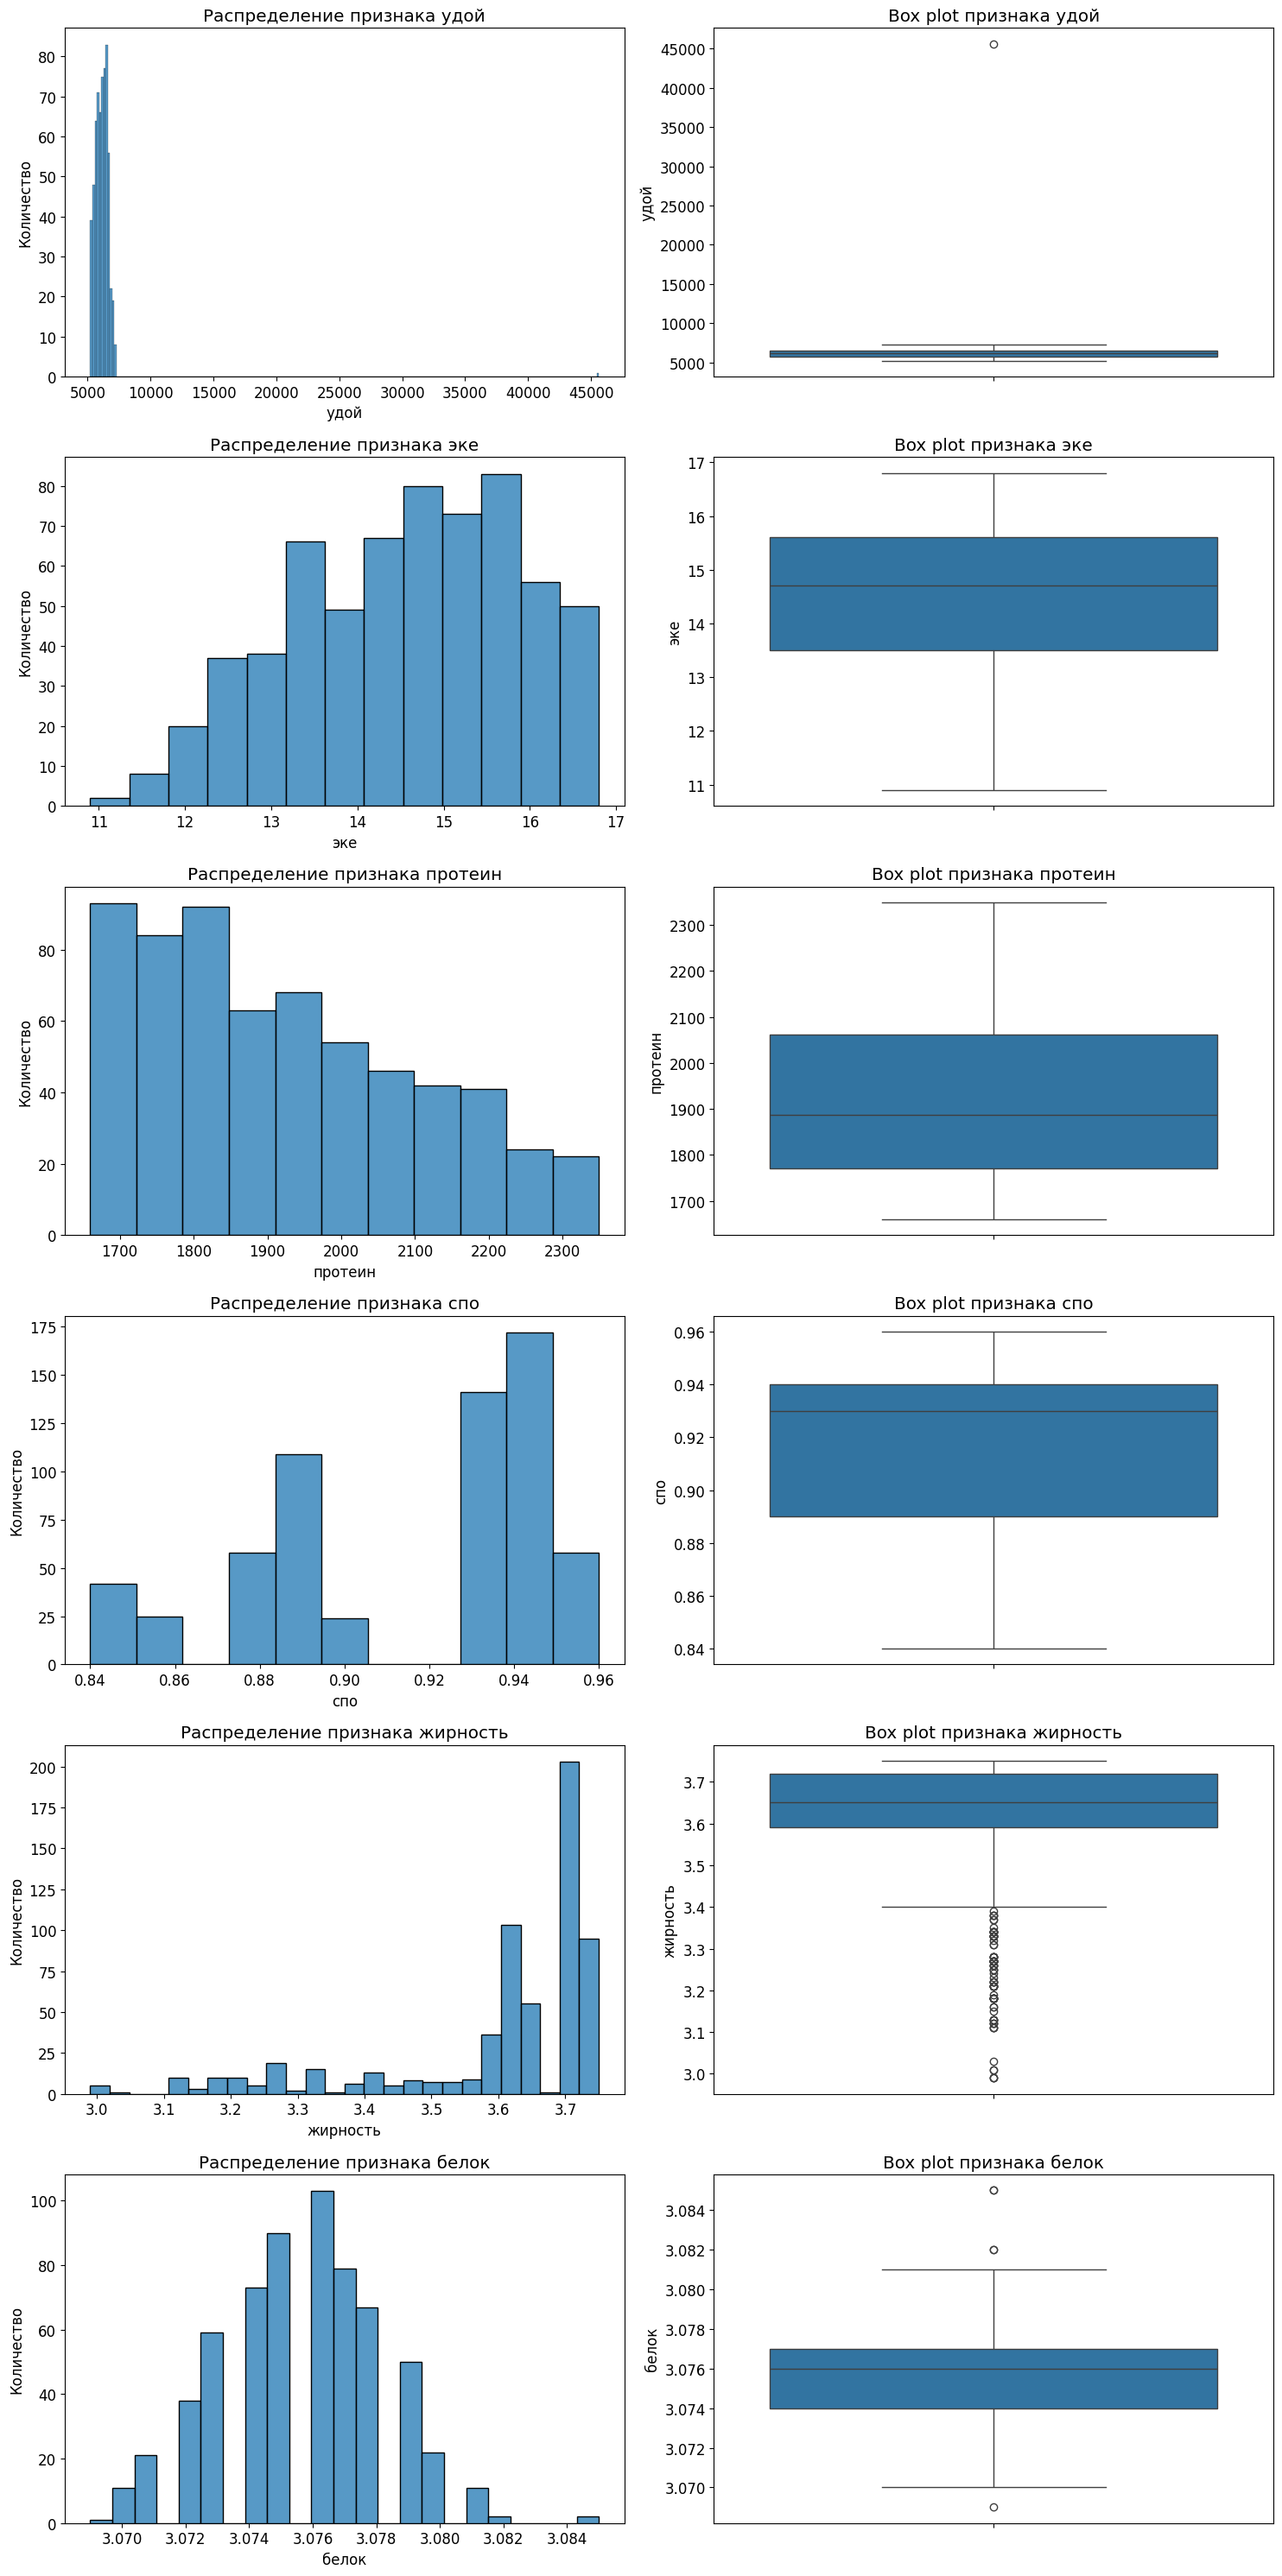

In [23]:
analyze_numeric_features(ferma_main)

#### Выброс
Заметен выброс для признака `удой`!

In [24]:
ferma_main.query('удой > 10000')

id   удой   эке  протеин  спо          порода   пастбище порода_отца  \
16  17  45616 11.50     1675 0.93  Вис Бик Айдиал  Холмистое      Айдиал   

    жирность  белок    вкус      возраст  
16      3.22   3.08  вкусно  более_2_лет

In [25]:
ferma_main = ferma_main.drop(index=16)

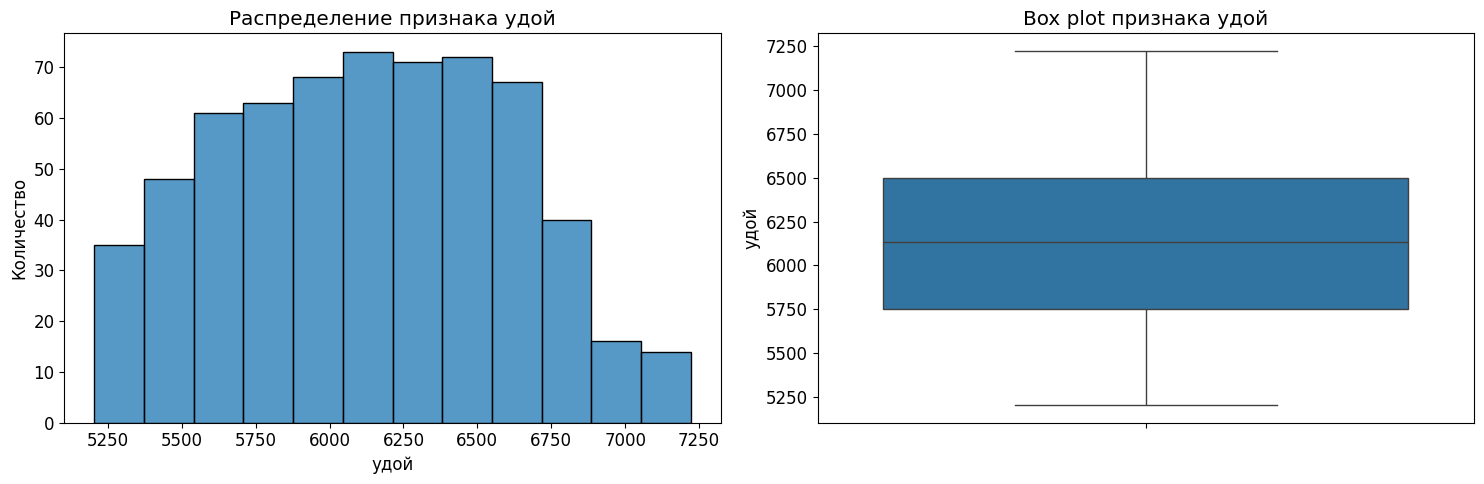

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=ferma_main, x='удой', ax=ax1)
ax1.set_title('Распределение признака удой')
ax1.set_ylabel('Количество')

sns.boxplot(data=ferma_main, y='удой', ax=ax2)
ax2.set_title('Box plot признака удой')

plt.tight_layout()
plt.show()

Статистический анализ числовых признаков:
       жирность  белок
count     20.00  20.00
mean       3.58   3.07
std        0.13   0.01
min        3.34   3.05
25%        3.51   3.06
50%        3.59   3.07
75%        3.65   3.08
max        3.77   3.08


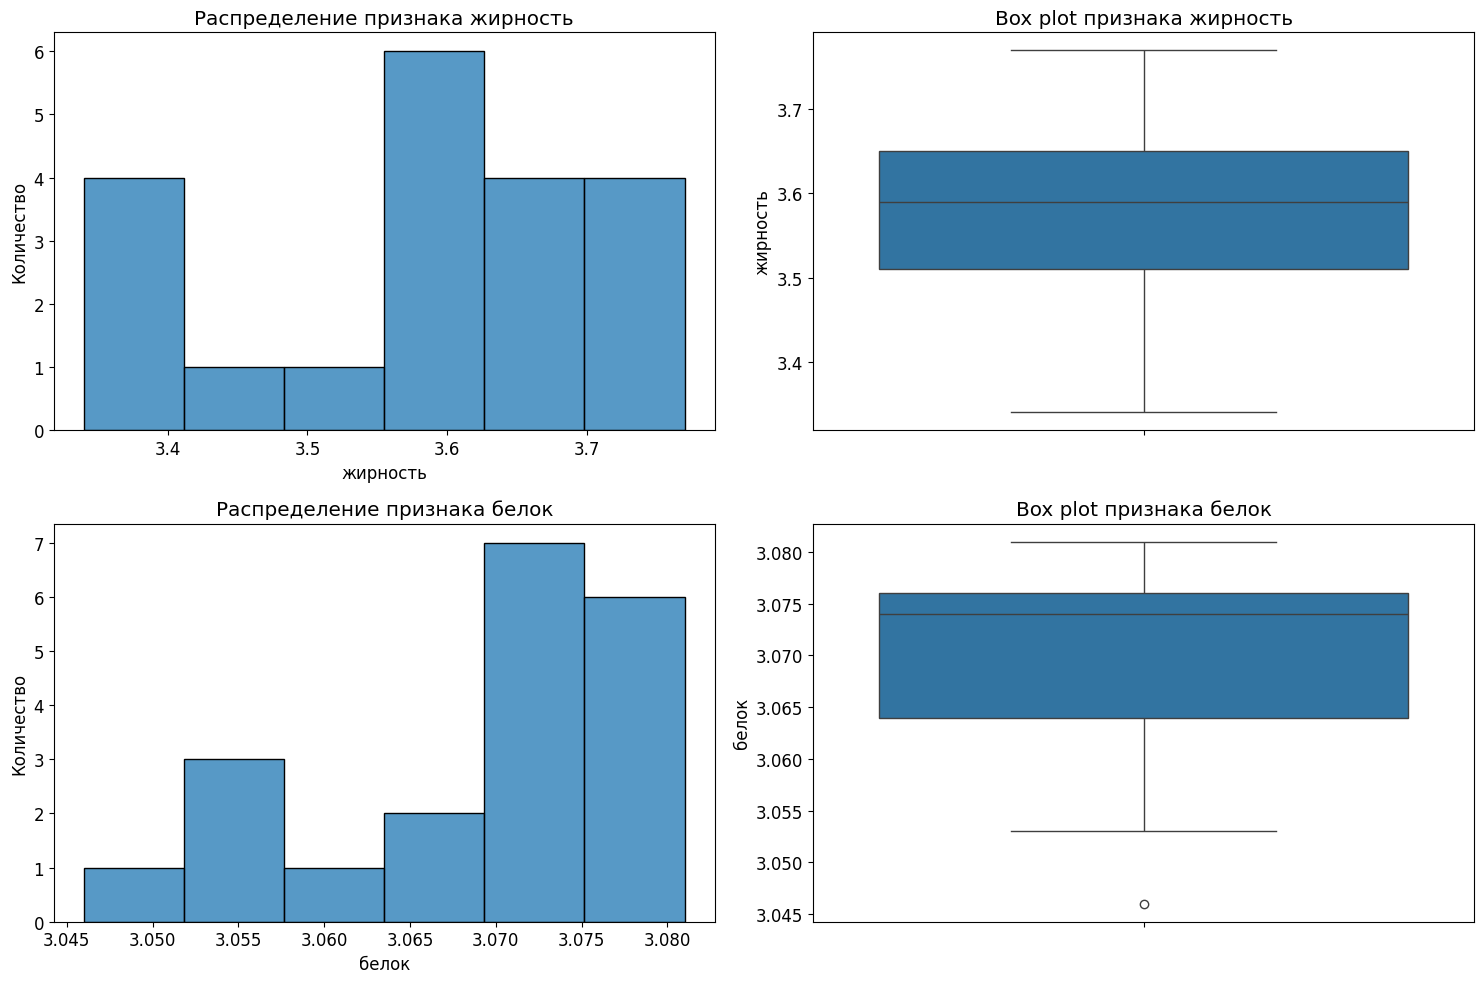

In [27]:
analyze_numeric_features(cow_buy)

### Статистический анализ категориальных признаков

#### Объединение фреймов `ferma_main` и `ferma_dad`
Думаю имеет смысл сейчас объеденить данные из фреймов ferma_main и ferma_dad, в связи с тем что `имя отца` может оказаться важным категориальным признаком.

In [28]:
ferma_merged = ferma_main.merge(ferma_dad, on='id', how='left')

In [29]:
def analyze_categorical_features(df, title="Категориальные признаки"):

   cat_cols = df.select_dtypes(include=['object']).columns
   
   n_cols = 3
   n_rows = (len(cat_cols) - 1) // n_cols + 1
   
   fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 6*n_rows))
   fig.suptitle(title, fontsize=16, y=1.05)
   
   if n_rows == 1 and n_cols == 1:
       axes = np.array([axes])

   elif n_rows == 1:
       axes = axes.reshape(1, -1)
   
   for idx, col in enumerate(cat_cols):
       row = idx // n_cols
       col_idx = idx % n_cols
       
       df[col].value_counts().plot(
           kind='pie',
           autopct='%1.1f%%',
           ax=axes[row, col_idx],
           ylabel=''
       )
       axes[row, col_idx].set_title(f'Распределение по признаку "{col}"')
   
   for idx in range(len(cat_cols), n_rows * n_cols):
       row = idx // n_cols
       col_idx = idx % n_cols
       fig.delaxes(axes[row, col_idx])
   
   plt.tight_layout()
   plt.show()

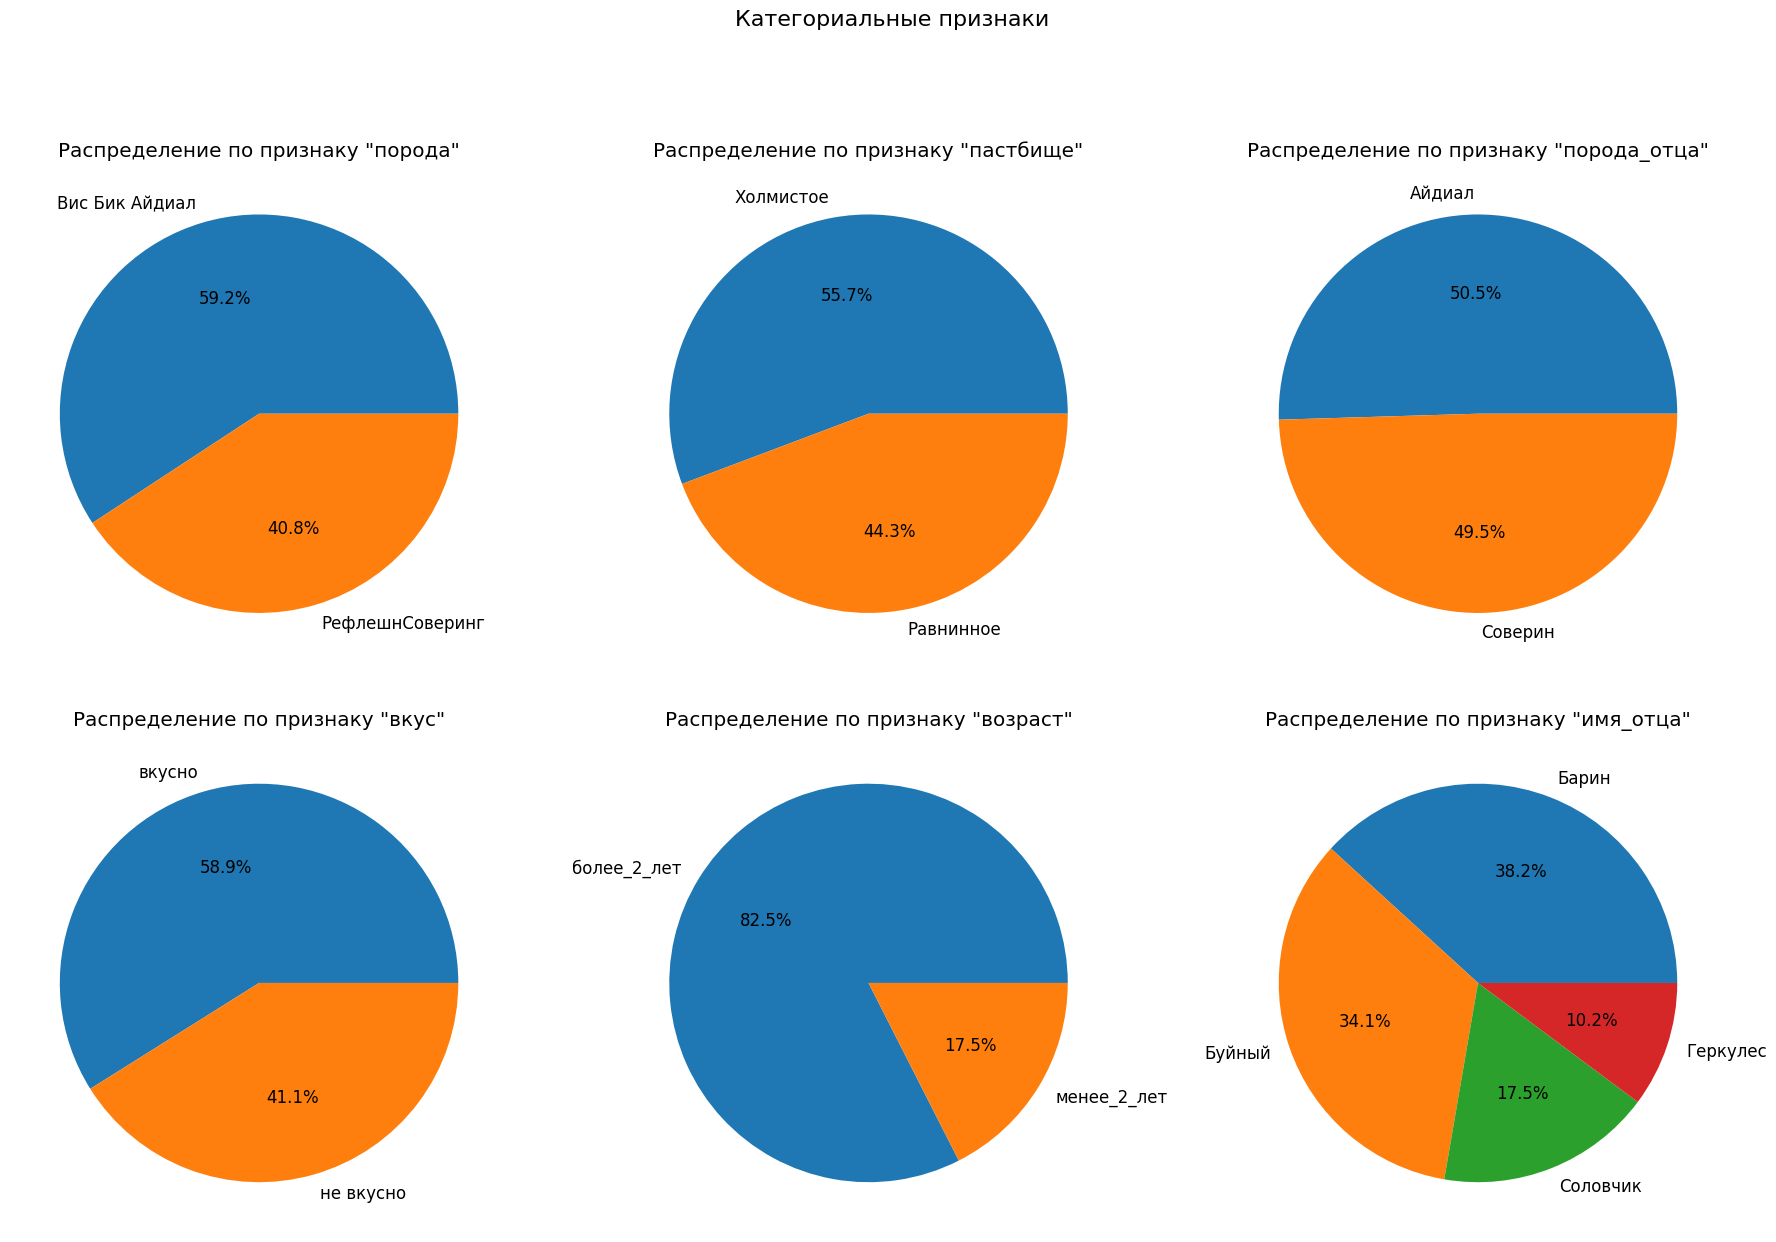

In [30]:
analyze_categorical_features(ferma_merged)

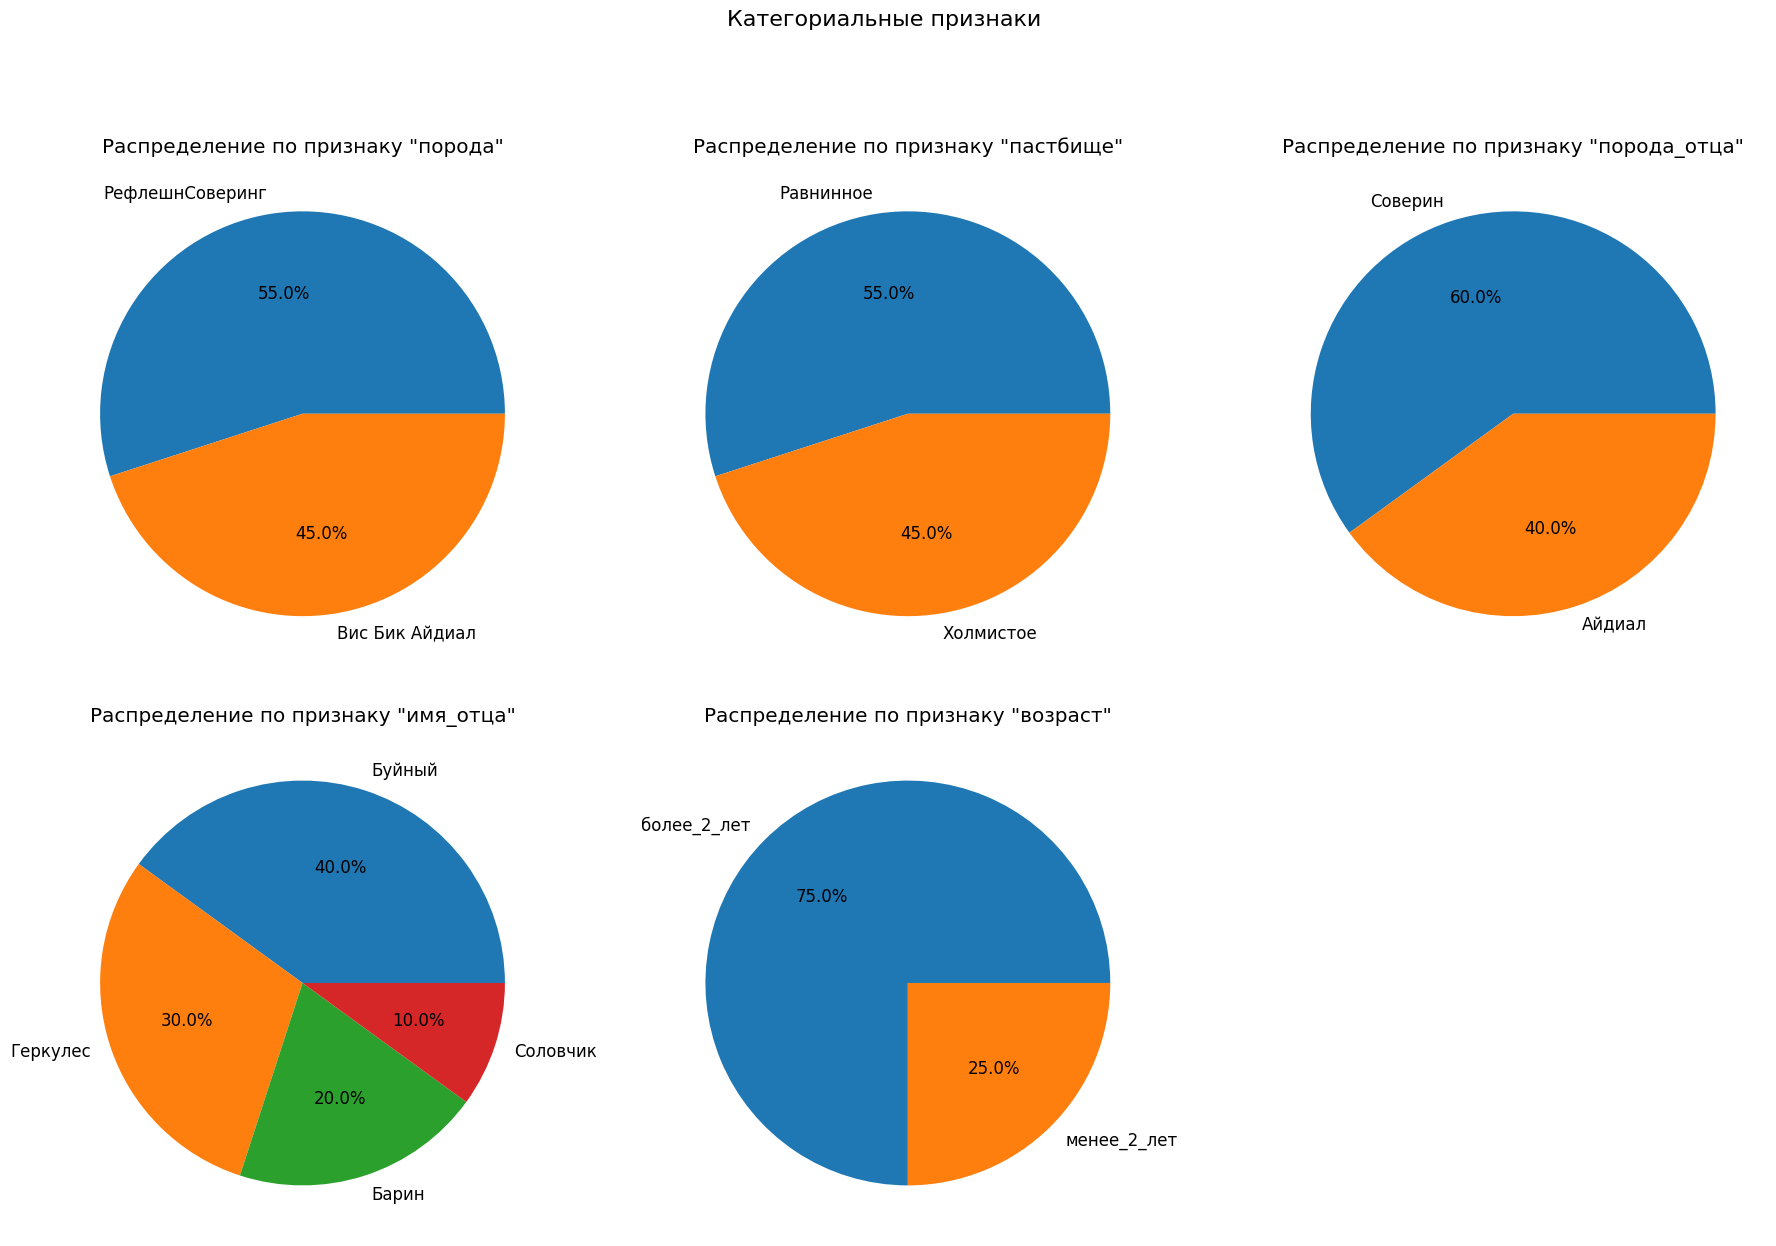

In [31]:
analyze_categorical_features(cow_buy)

Для ревьюера:

    Видя `неполное` совпадение `породы отца` и `породы коровы`, возникают мысли с бекграундом в сельсхое хозяйство и это некажется ошибкой.
    Да, возможно это действительно ошибка и разные именования пород это "допущение" которое надо исправить, однако, приведу пару примеров:
    1. Ризет Шнауцер, Миттель Шнауцер и Шнауцер - породы собак имеющие общее происхождение но совершенно разные характеристики
    2. Гибрид мальтийской болонки и пуделя - Мальтипу (стоит дорого), существует только как гибрид первого поколения, гибрид второго поколения уже - просто дворняга
    3. Карника Тройзек, Карника Тройзек Винтерсбах, Карника Тройзек 1012, Карника Тройзек 07, Тройзек 1075, Карника Пешец, Карника Варроатолеранц - крайнепопулярная порода пчёл, родом из Cловении, региона Карниола, но за дополнительными словами скрывается `линия селекции` и как следствие варьируются полезные качества (признаки такие как: ройливость, устойчивость к болезням и т.д.) что собственно чуть менее тонко чем субъективное суждение "вкусно/невкусно"
    4. В молочном скотоводстве часто практикуется межпородное скрещивание для предотвращения инбридинга и получения эффекта гетерозиса, возможно это несовпадение, а часть плановой селекционной работы.
    Возможно исправляя породу "коровы" потеряю важный признак, с той же вероятностью сделаю ошибку.
    P.S. исправлять небуду, нужен комментарий.

In [32]:
print('Распределение пород отцов для каждой породы коров в основном стаде:')
print(pd.crosstab(ferma_merged['порода'], ferma_merged['порода_отца'], normalize='index')*100)

Распределение пород отцов для каждой породы коров в основном стаде:
порода_отца      Айдиал  Соверин
порода                          
Вис Бик Айдиал    53.49    46.51
РефлешнСоверинг   46.09    53.91


In [33]:
print('Распределение пород отцов для каждой породы коров в стаде на продажу:')
print(pd.crosstab(cow_buy['порода'], cow_buy['порода_отца'], normalize='index')*100)

Распределение пород отцов для каждой породы коров в стаде на продажу:
порода_отца      Айдиал  Соверин
порода                          
Вис Бик Айдиал    33.33    66.67
РефлешнСоверинг   45.45    54.55


Решусь и добавлю признак 'гибрид', кажется есть основания.

#### Добавление категориального признака `гибрид`

In [34]:
def set_hybrid(row):
    if row['порода'] == 'Вис Бик Айдиал':
        return 'чистопородная' if row['порода_отца'] == 'Айдиал' else 'гибрид'
    else:
        return 'чистопородная' if row['порода_отца'] == 'Соверин' else 'гибрид'

In [35]:
ferma_merged['гибрид'] = ferma_merged.apply(set_hybrid, axis=1)

In [36]:
cow_buy['гибрид'] = cow_buy.apply(set_hybrid, axis=1)

In [37]:
print("Распределение по гибридности в основном стаде:")
print(ferma_merged['гибрид'].value_counts(normalize=True) * 100)

Распределение по гибридности в основном стаде:
гибрид
чистопородная   53.66
гибрид          46.34
Name: proportion, dtype: float64


In [38]:
print("\nРаспределение по гибридности в стаде на продажу:")
print(cow_buy['гибрид'].value_counts(normalize=True) * 100)


Распределение по гибридности в стаде на продажу:
гибрид
гибрид          55.00
чистопородная   45.00
Name: proportion, dtype: float64


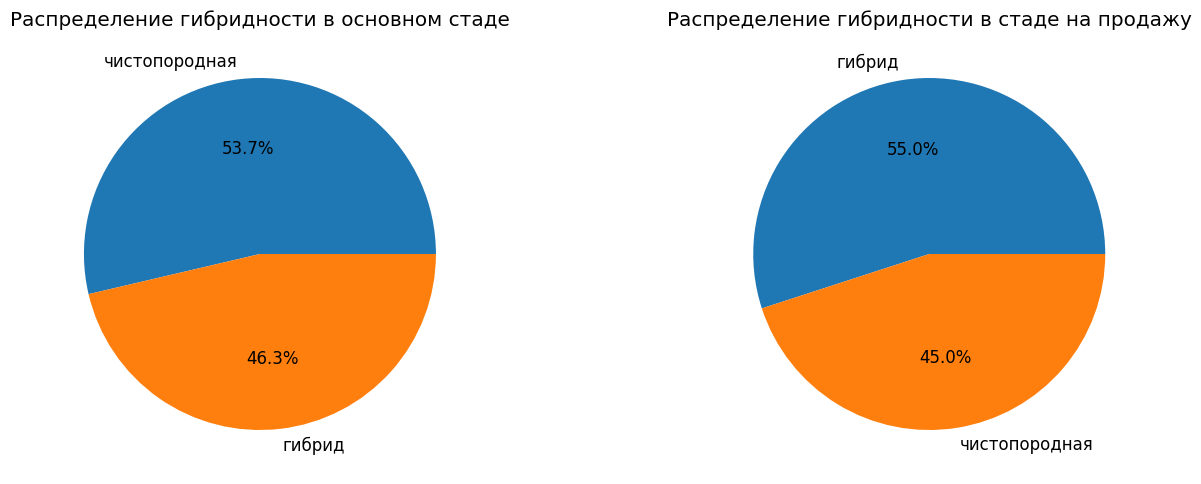

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ferma_merged['гибрид'].value_counts().plot(
   kind='pie',
   autopct='%1.1f%%',
   ax=ax1,
   ylabel=''
)
ax1.set_title('Распределение гибридности в основном стаде')

cow_buy['гибрид'].value_counts().plot(
   kind='pie',
   autopct='%1.1f%%',
   ax=ax2,
   ylabel=''
)
ax2.set_title('Распределение гибридности в стаде на продажу')

plt.tight_layout()
plt.show()

In [40]:
print("Проверка расчета гибридности в стаде на продажу:")
print(cow_buy.groupby(['порода', 'порода_отца'])['гибрид'].value_counts())

Проверка расчета гибридности в стаде на продажу:
порода           порода_отца  гибрид       
Вис Бик Айдиал   Айдиал       чистопородная    3
                 Соверин      гибрид           6
РефлешнСоверинг  Айдиал       гибрид           5
                 Соверин      чистопородная    6
Name: count, dtype: int64


In [41]:
print("Проверка расчета гибридности в основном стаде:")
print(ferma_merged.groupby(['порода', 'порода_отца'])['гибрид'].value_counts())

Проверка расчета гибридности в основном стаде:
порода           порода_отца  гибрид       
Вис Бик Айдиал   Айдиал       чистопородная    199
                 Соверин      гибрид           173
РефлешнСоверинг  Айдиал       гибрид           118
                 Соверин      чистопородная    138
Name: count, dtype: int64


### Вывод
На основе анализа статистики и графиков можно сделать следующие выводы:
1. Обнаружен и удалён выброс.
2. Удой - после удаления выброса, распределение стало похоже на нормальное. Средний удой 6188, медианный 6133, что очень близко.
Большинство коров дают от 5751 до 6501 литра, возможно это говорит о `здоровом` стаде без серьёзных проблем в содержании.
3. Жирность - средняя 3.65%, медианная 3.6%, Большинство значений находится в диапазоне от 3.59% до 3.72%, однако есть животные жирность молока которых ниже 3.5% думаю стоит обратить на них внимание, но снижение жирности может происходить в следствии естественных физиологических процессов.
4. Белок - максимальное значение 3.08%, медиана 3.08%, среднее также 3.08%, минимальное 3.07% можно сделать вывод что содержание белка очень стабильное.
5. ЭКЕ (Энергетическая кормовая единица) - распределение близко к нормальному, большая часть значений находиться в диапазоне от 13.5 до 15.6, минимальное значение - 10.9, максимальное 16.8, медианное 14.7
6. СПО (Сахаро-протеиновое отношение) - значения колеблются в узком диапазоне от 0.84 до 0.96, с медианным 0.93.
Заметны два пика в распределении - около 0.88 и 0.94, такое распределение может говорить о разных типах рационов, что в принципе является нормальной практикой в зависимости от периода лактации/стельности.
7. Коровы на продажу имеют схожие характеристики с основным стадом:
    1. Жирность - Среднее значение 3.58%, диапазон 3.34-3.77% соответствует показателям основного стада, нет коров с критически низкой или высокой жирностью.
    2. Белок - Стабильный показатель около 3.07%, почти такой же узкий диапазон как в основном стаде от 3.05 до 3.08%
8. Подобная согласованность показателей между двумя стадами может является хорошим знаком :-)
9. Породный состав:
- В основном стаде преобладает порода Вис Бик Айдиал (59.2% против 40.8% РефлешнСоверинг)
- В стаде на продажу наоборот - больше РефлешнСоверинг (55% против 45% Вис Бик Айдиал)
10. Пастбище:
- В основном стаде: 55.7% на холмистых и 44.3% на равнинных пастбищах
- В стаде на продажу: почти аналогичное распределение - 55% на холмистых и 45% на равнинных
- Это говорит о схожих условиях содержания в обоих хозяйствах
11. Генетика:
- В основном стаде почти равное соотношение 50.5% Айдиал и 49.5% Соверин
- В стаде на продажу больше коров от быков породы Соверин 60% против 40% Айдиал
- Можно строить гипотезу о том что в обоих стадах применяется межпородное скрещивание и вводить признак "гибрид"
12. Возрастной состав:
- Основное стадо более зрелое: 82.5% коров старше 2 лет
- Стадо на продажу моложе: 75% старше 2 лет и 25% младше
13. Добавлен категориальный признак `гибрид`

## Корреляционный анализ

### Кодирование категориальных признаков
Нам необходимо вычислить коофиценты корреляции для `всех` признаков, в связи с тем что коофицент корреляции можно вычислить только для числовых признаков, логично будет закодировать категориальные признаки.

In [42]:
df_corr = ferma_merged.copy()

In [43]:
df_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 628 entries, 0 to 627
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           628 non-null    int64  
 1   удой         628 non-null    int64  
 2   эке          628 non-null    float64
 3   протеин      628 non-null    int64  
 4   спо          628 non-null    float64
 5   порода       628 non-null    object 
 6   пастбище     628 non-null    object 
 7   порода_отца  628 non-null    object 
 8   жирность     628 non-null    float64
 9   белок        628 non-null    float64
 10  вкус         628 non-null    object 
 11  возраст      628 non-null    object 
 12  имя_отца     628 non-null    object 
 13  гибрид       628 non-null    object 
dtypes: float64(4), int64(3), object(7)
memory usage: 68.8+ KB


In [44]:
df_corr = df_corr.drop('id', axis=1)

In [45]:
df_corr = pd.get_dummies(df_corr, columns=['порода', 'пастбище', 'порода_отца', 'вкус', 'возраст', 'имя_отца', 'гибрид'])

In [46]:
correlations = df_corr.corr()

In [47]:
print('Корреляционная матрица:')
print(correlations.round(3))

Корреляционная матрица:
                        удой   эке  протеин   спо  жирность  белок  \
удой                    1.00  0.77     0.45  0.81      0.60   0.00   
эке                     0.77  1.00     0.39  0.75      0.64  -0.01   
протеин                 0.45  0.39     1.00  0.45      0.36   0.23   
спо                     0.81  0.75     0.45  1.00      0.63   0.07   
жирность                0.60  0.64     0.36  0.63      1.00  -0.03   
белок                   0.00 -0.01     0.23  0.07     -0.03   1.00   
порода_Вис Бик Айдиал  -0.07 -0.10    -0.01 -0.06     -0.05   0.29   
порода_РефлешнСоверинг  0.07  0.10     0.01  0.06      0.05  -0.29   
пастбище_Равнинное     -0.13 -0.10    -0.07 -0.06      0.02  -0.11   
пастбище_Холмистое      0.13  0.10     0.07  0.06     -0.02   0.11   
порода_отца_Айдиал      0.39  0.10     0.01  0.22      0.04   0.06   
порода_отца_Соверин    -0.39 -0.10    -0.01 -0.22     -0.04  -0.06   
вкус_вкусно             0.11  0.21     0.15  0.19      0.09   0.13

### Тепловая карта корреляций

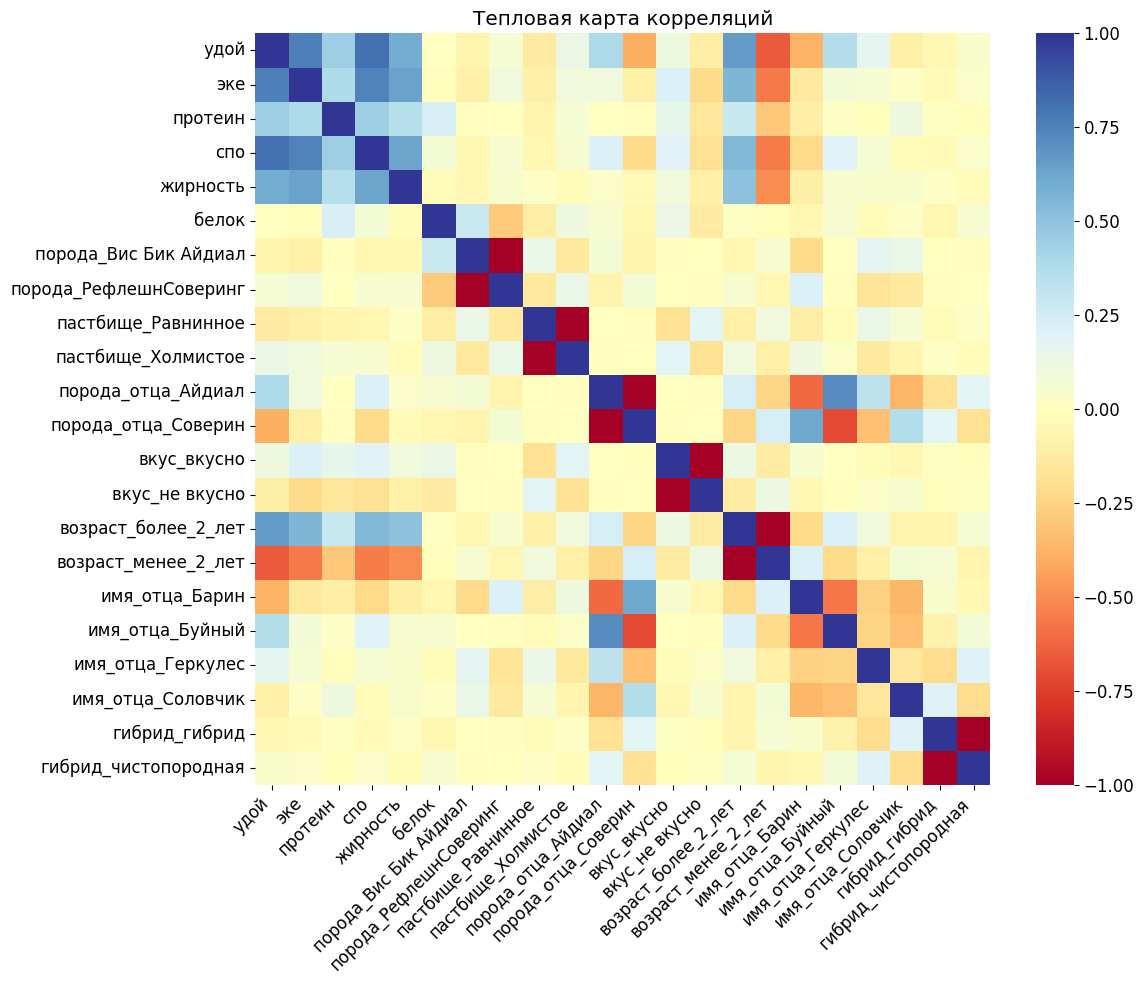

In [48]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlations, 
           annot=False,
           cmap='RdYlBu', #пробовал разные
           )

plt.title('Тепловая карта корреляций')

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

In [49]:
print("Проверка соответствия породы и имени отца:")
print(pd.crosstab(ferma_merged['порода_отца'], ferma_merged['имя_отца']))

Проверка соответствия породы и имени отца:
имя_отца     Барин  Буйный  Геркулес  Соловчик
порода_отца                                   
Айдиал          28     214        64        11
Соверин        212       0         0        99


### Анализ тепловой карты

Анализируя тепловую карту корреляций, можно выделить следующие взаимосвязи:
1. Сильные корреляции:
    - Чем выше энергетическая ценность корма, тем выше удой - логично.
    - Удой и жирность, коровы с высоким уровнем удоя дают более жирное молоко.
    - ЭКЕ и жирность, энергетически богатый корм связан с повышенной жирностью молока
    - Жирность и СПО, выше сахаро-протеиновое отношение - выше жирность
2. Умеренные корреляции:
    - Удой и протеин, увеличение протеина в корме умеренно повышает удой
    - Протеин и СПО, закономерная связь компонентов рациона
    - Возраст более 2 лет и удой, взрослые коровы дают больше молока - логично
3. Слабые корреляции:
    - Порода отца Айдиал и удой, возможно, эта линия быков даёт более продуктивное потомство
    - Имя отца и удой, возможно потомство "Буйного", более продуктивно
    - Вкус молока слабо, но коррелирует с типом пастбища, возможно это связано с составом растительного покрова.
4. Аномалии:
    - Думаю имя отца и порода отца должны иметь строгое соответствие.
    - Мы видим, что одно и то же имя встречается у быков разных пород, или одна порода встречается у быков с разными именами (не соответствующими этой породе), это может указывать на:
        - Ошибки в данных
        - Проблемы с учетом
        - Возможные опечатки в именах или породах
    
    

### Диаграммы рассеяния для признака Удой

In [50]:
def plot_scatter_with_categories(df, x_features, y_feature, categorical_features, figsize=(20, 15)):
   n_x = len(x_features)
   n_cat = len(categorical_features)
   n_rows = n_cat
   n_cols = n_x
   
   fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
   
   for i, cat_feature in enumerate(categorical_features):
       for j, x_feature in enumerate(x_features):
           sns.scatterplot(
               data=df,
               x=x_feature,
               y=y_feature,
               hue=cat_feature,
               alpha=0.6,
               ax=axes[i, j]
           )
           axes[i, j].set_title(f'{y_feature} от {x_feature} по {cat_feature}')
   
   plt.tight_layout()
   plt.show()

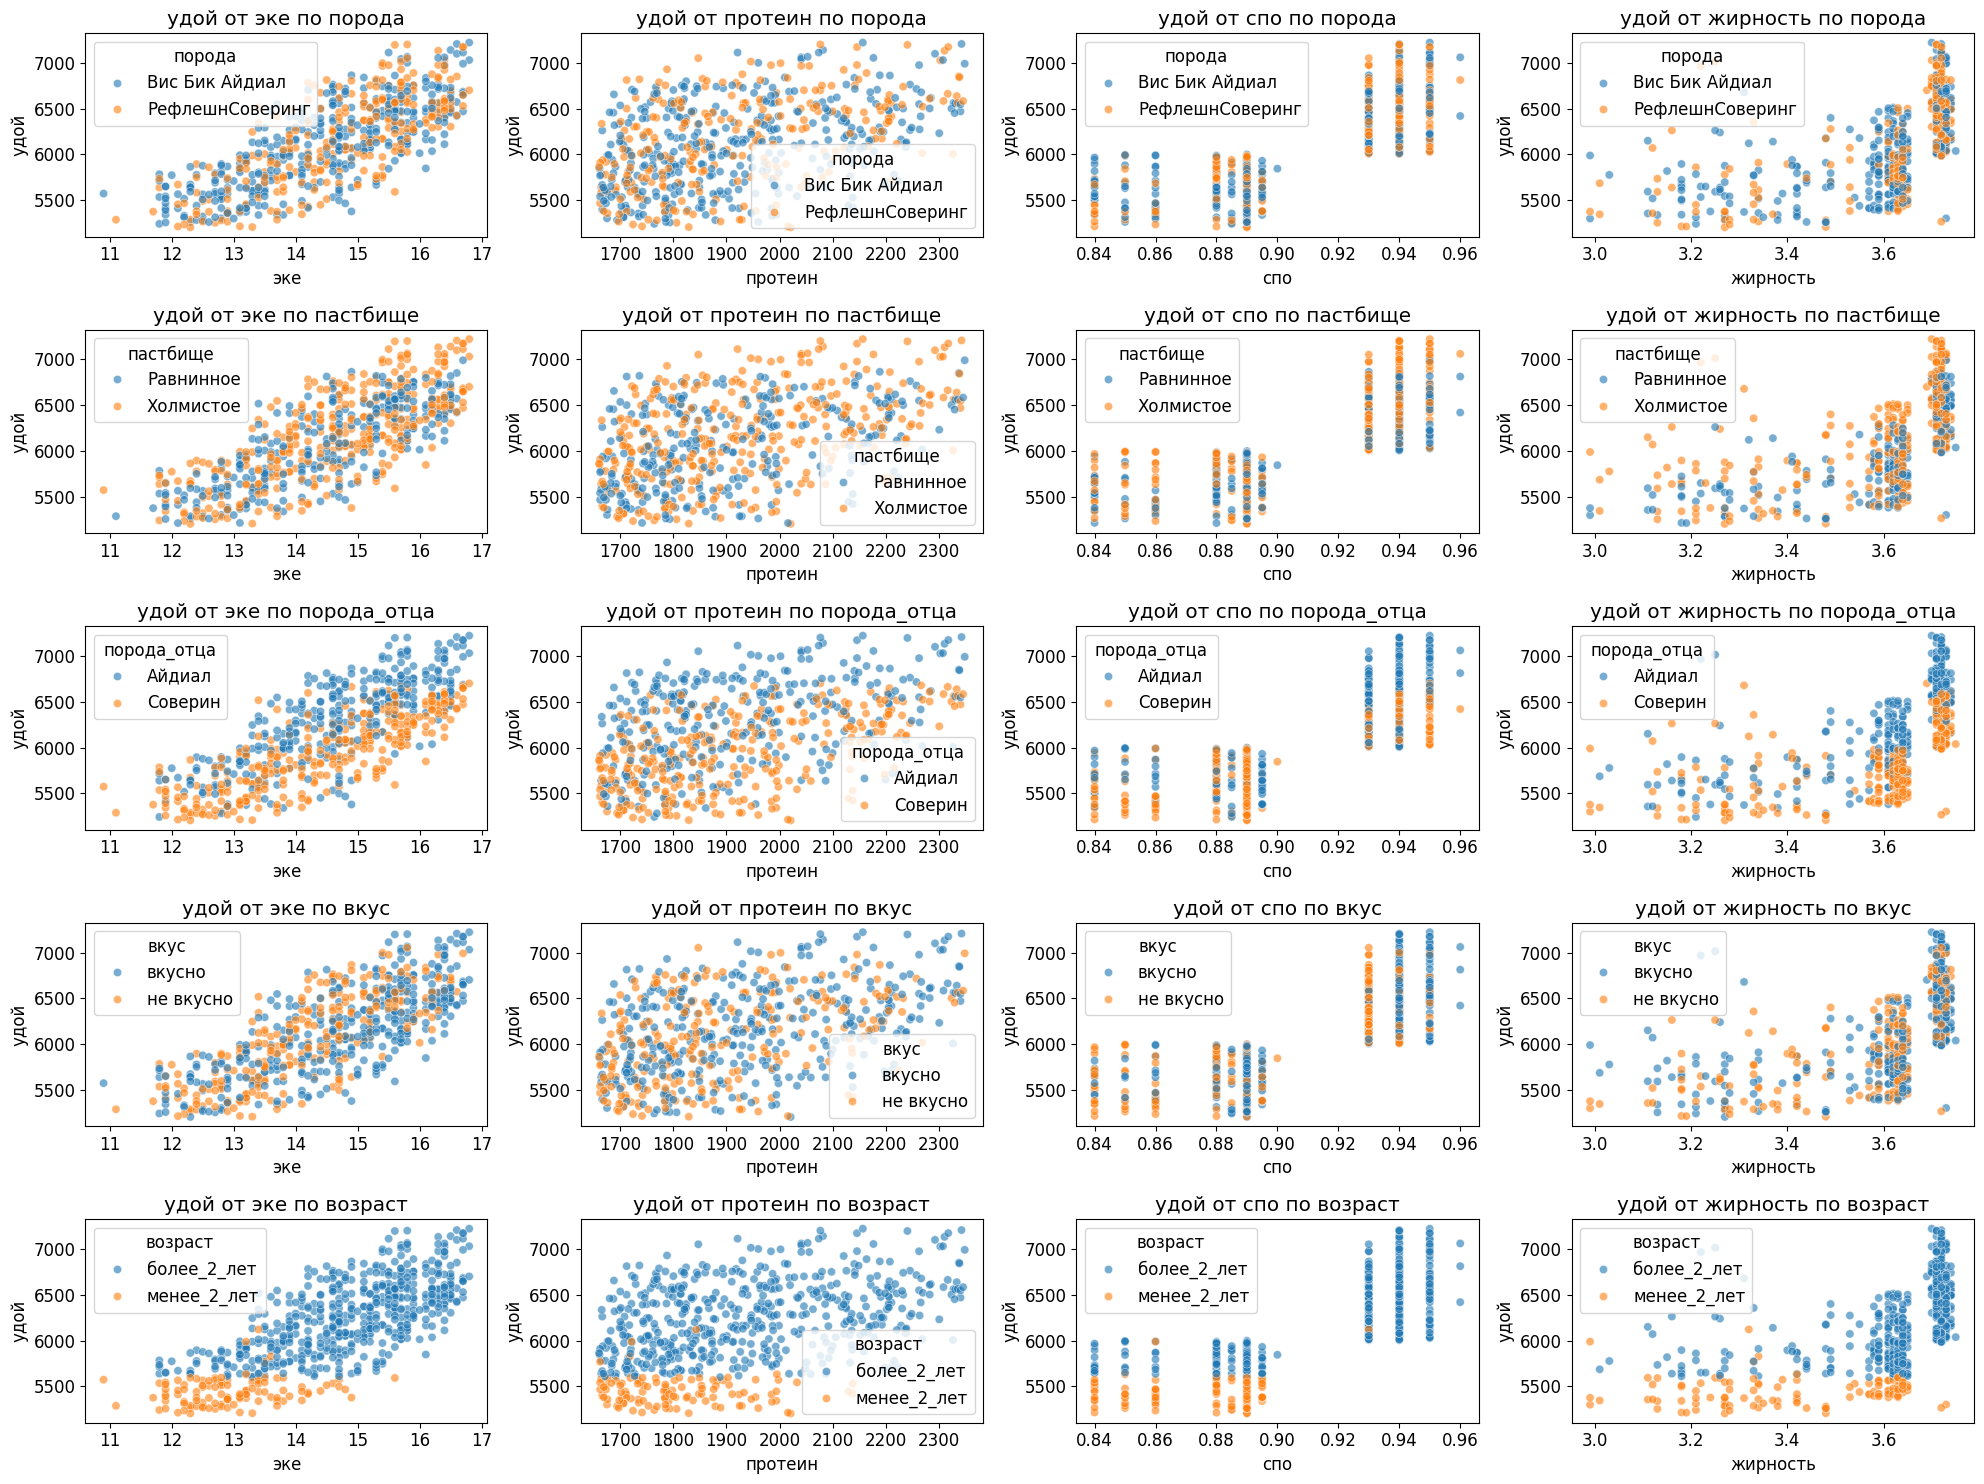

In [51]:
x_features = ['эке', 'протеин', 'спо', 'жирность']
y_feature = 'удой'
categorical_features = ['порода', 'пастбище', 'порода_отца', 'вкус', 'возраст']

plot_scatter_with_categories(ferma_merged, x_features, y_feature, categorical_features)

In [52]:
ferma_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 628 entries, 0 to 627
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           628 non-null    int64  
 1   удой         628 non-null    int64  
 2   эке          628 non-null    float64
 3   протеин      628 non-null    int64  
 4   спо          628 non-null    float64
 5   порода       628 non-null    object 
 6   пастбище     628 non-null    object 
 7   порода_отца  628 non-null    object 
 8   жирность     628 non-null    float64
 9   белок        628 non-null    float64
 10  вкус         628 non-null    object 
 11  возраст      628 non-null    object 
 12  имя_отца     628 non-null    object 
 13  гибрид       628 non-null    object 
dtypes: float64(4), int64(3), object(7)
memory usage: 68.8+ KB


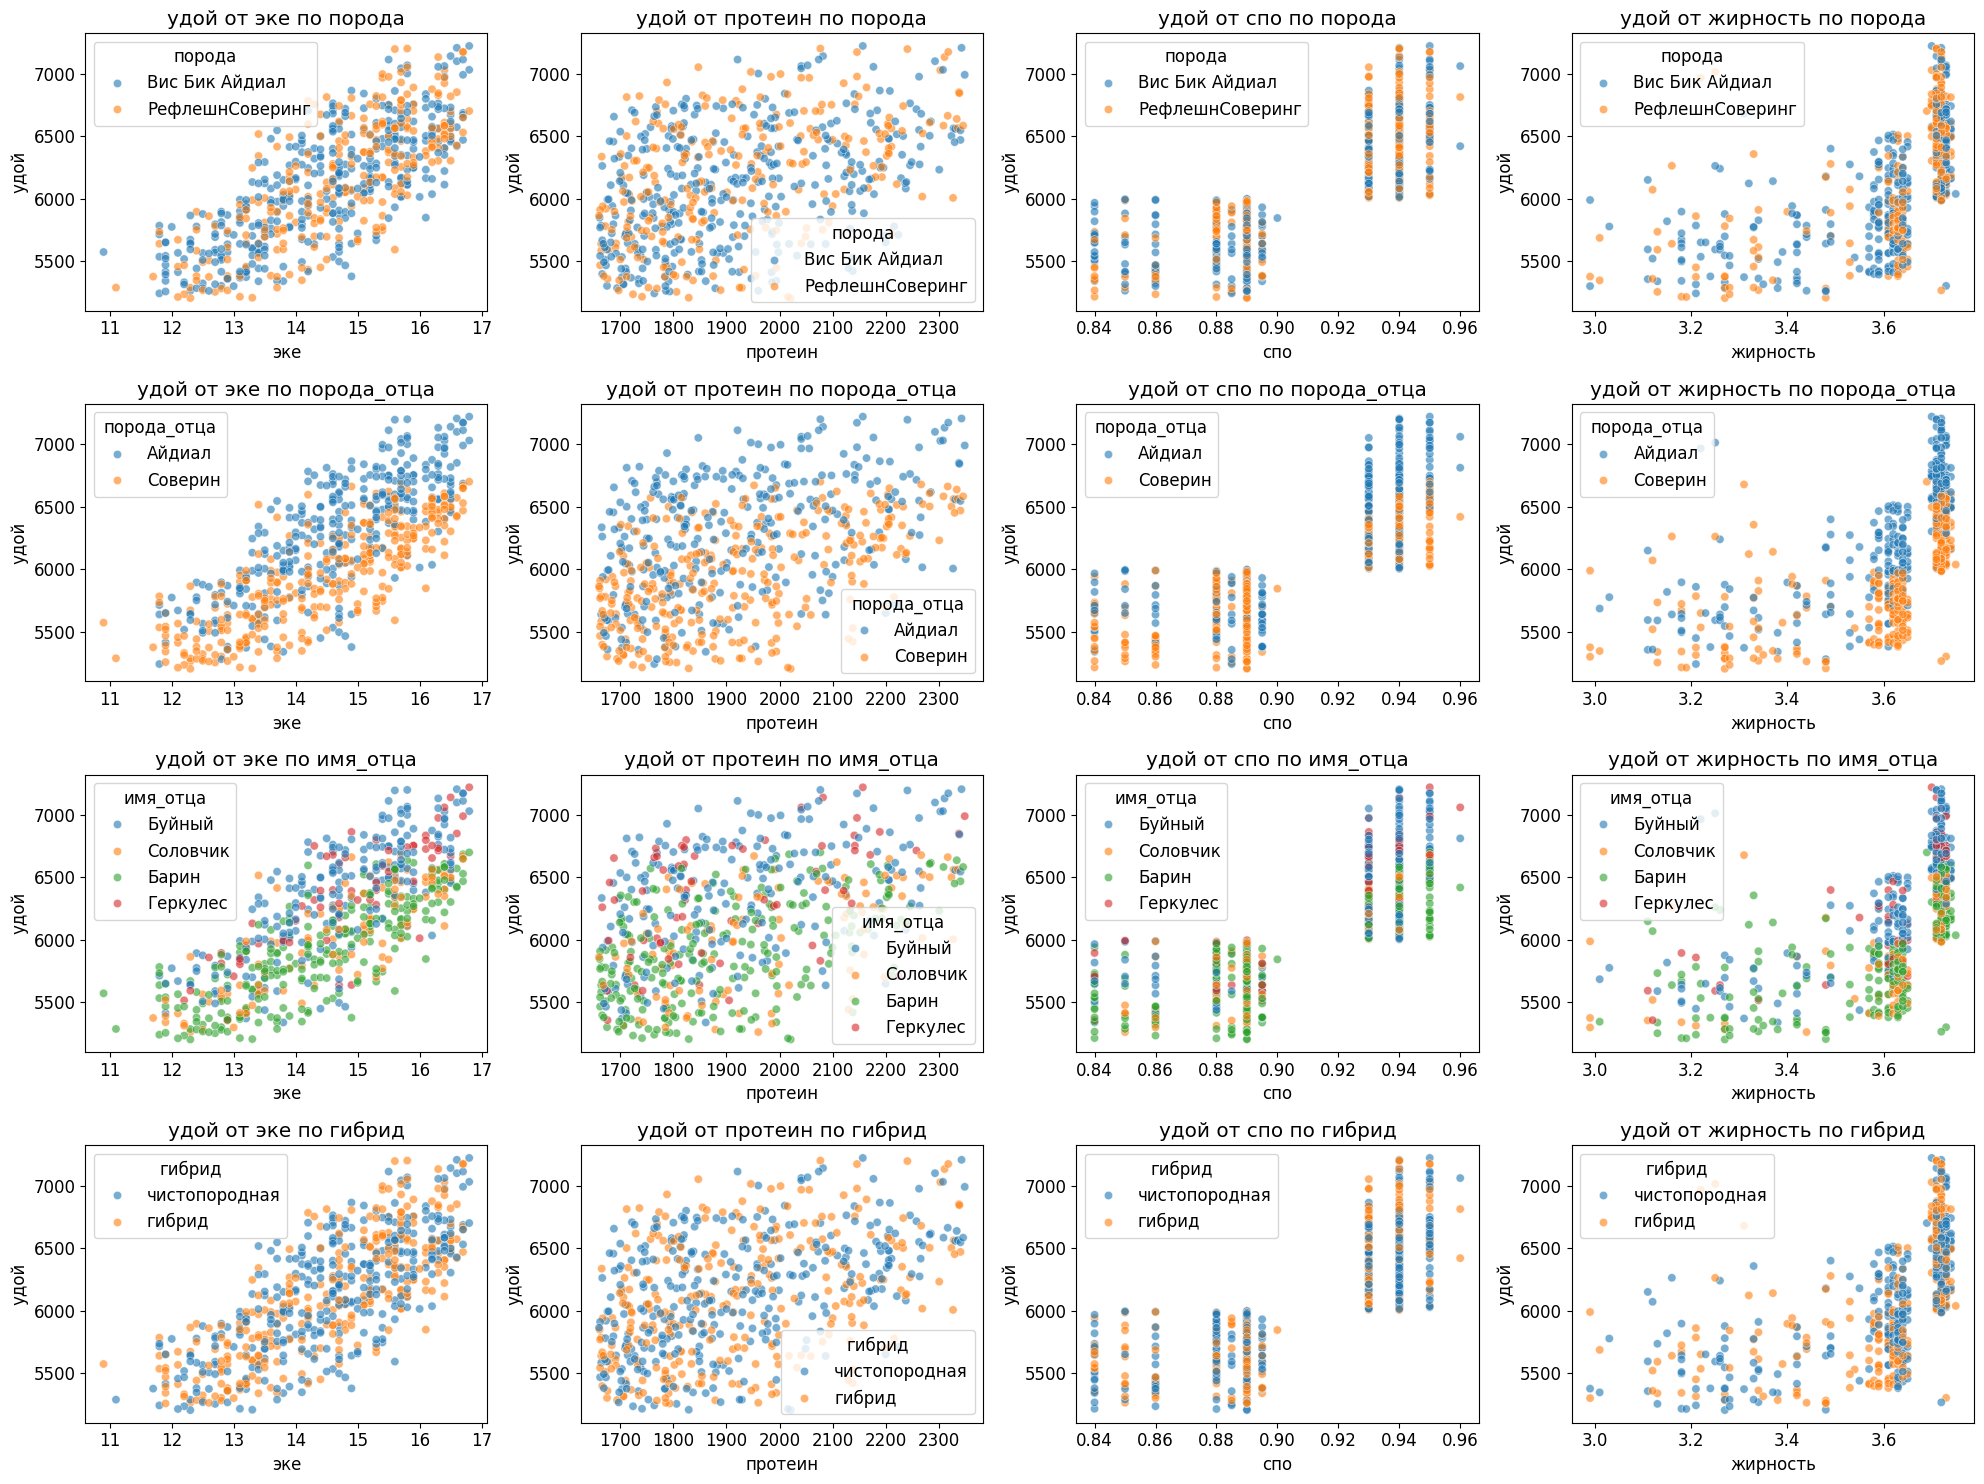

In [53]:
x_features = ['эке', 'протеин', 'спо', 'жирность']
y_feature = 'удой'
categorical_features = ['порода', 'порода_отца', 'имя_отца', 'гибрид']

plot_scatter_with_categories(ferma_merged, x_features, y_feature, categorical_features)

### Выводы
1. Удой прямо зависит от ЭКЕ
2. Удой прямо зависит от Возраста
3. Удой завист от СПО, наблюдается кластеризация
4. Вероятно ЭКЕ и СПО мультиколлинеарны, СПО можно преобразовать в качественный признак.
5. Кажется виден устойцивый тренд связи имени отца и удоя.


## Обучение модели линейной регрессии
### Подготовка данных
#### Признаки

#### Обучение первой модели

In [54]:
def run_model_lr(numeric_features, categorical_features, target, df):
    features = numeric_features + categorical_features

    RANDOM_STATE = 42

    X = df[features]
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        random_state=RANDOM_STATE
    )

    scaler = StandardScaler()
    X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
    X_test[numeric_features] = scaler.transform(X_test[numeric_features])

    #encoder = OneHotEncoder(drop='first', sparse_output=False)
    #X_train[categorical_features] = encoder.fit_transform(X_train[categorical_features])
    #X_test[categorical_features] = encoder.transform(X_test[categorical_features])
    X_train = pd.get_dummies(X_train, drop_first=False)
    X_test = pd.get_dummies(X_test, drop_first=False)

    model_lr = LinearRegression()
    model_lr.fit(X_train, y_train)

    predictions = model_lr.predict(X_test)

    train_predictions = model_lr.predict(X_train)
    train_errors = y_train - train_predictions
    lower_quantile = np.percentile(train_errors, 2.5)
    upper_quantile = np.percentile(train_errors, 97.5)

    r2_test = r2_score(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = mse**0.5
    
    residuals = y_test - predictions

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    axes[0].hist(residuals, bins=50)
    axes[0].axvline(x=0, color='r', linestyle='--', alpha=0.5)
    axes[0].axvline(x=residuals.mean(), color='g', linestyle='--', alpha=0.5)
    axes[0].set_title('Гистограмма распределения остатков')
    axes[0].set_xlabel('Остатки')
    axes[0].set_ylabel('Количество')

    axes[1].scatter(predictions, residuals)
    axes[1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
    axes[1].set_xlabel('Предсказания модели')
    axes[1].set_ylabel('Остатки')
    axes[1].set_title('Анализ дисперсии')

    plt.tight_layout()
    plt.show()

    print(f'R2 на тестовой выборке: {r2_test:.3f}')
    print(f'MAE на тестовой выборке: {mae:.3f}')
    print(f'MSE на тестовой выборке: {mse:.3f}')
    print(f'RMSE на тестовой выборке: {rmse:.3f}')

    print(f'\nДоверительный интервал прогноза (95%):')
    print(f'Нижняя граница ошибки: {lower_quantile:.2f} кг молока')
    print(f'Верхняя граница ошибки: {upper_quantile:.2f} кг молока')

    return model_lr, scaler, X_train.columns


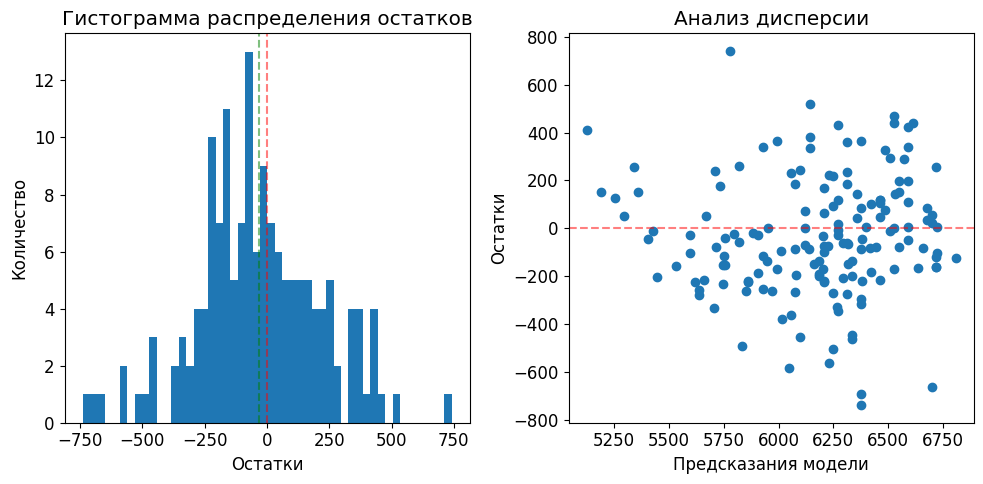

R2 на тестовой выборке: 0.687
MAE на тестовой выборке: 198.121
MSE на тестовой выборке: 63667.526
RMSE на тестовой выборке: 252.324

Доверительный интервал прогноза (95%):
Нижняя граница ошибки: -480.91 кг молока
Верхняя граница ошибки: 454.69 кг молока


(LinearRegression(),
 StandardScaler(),
 Index(['эке', 'порода_Вис Бик Айдиал', 'порода_РефлешнСоверинг',
        'пастбище_Равнинное', 'пастбище_Холмистое', 'возраст_более_2_лет',
        'возраст_менее_2_лет', 'порода_отца_Айдиал', 'порода_отца_Соверин'],
       dtype='object'))

In [55]:
numeric_features = ['эке']

categorical_features = ['порода', 'пастбище', 'возраст', 'порода_отца']

target = 'удой'

run_model_lr(numeric_features, categorical_features, target, ferma_merged)

#### Вывод
- Гистограмма:
    * Гистограмма показывает распределение, близкое к нормальному
    * Наблюдается небольшой перекос в правую сторону
    * Большинство остатков сконцентрировано в диапазоне ±250 кг молока
    * Есть несколько выбросов в области ±500-750 кг
- Дисперсия:
    * На графике не наблюдается явных систематических трендов, что хорошо для линейной модели
    * Разброс остатков увеличивается с ростом предсказанных значений
* R2 = 0.687 
* Учитывая, что нижняя граница R2 - бесконечность, а верхняя - 1, полученное значение говорит о достаточно хорошем качестве модели
* Тем не менее, есть потенциал для улучшения





#### Обучение второй модели
1. Добавим признак СПО, предвательно категоризируем его.
2. Введём признак ЭКЕ в квадрате.

In [56]:
def categorize_spo(value):
    return 'высокое' if value > 0.92 else 'низкое'

In [57]:
ferma_merged['спо_кат'] = ferma_merged['спо'].apply(categorize_spo)

In [58]:
ferma_merged['эке_кв'] = ferma_merged['эке'] ** 2

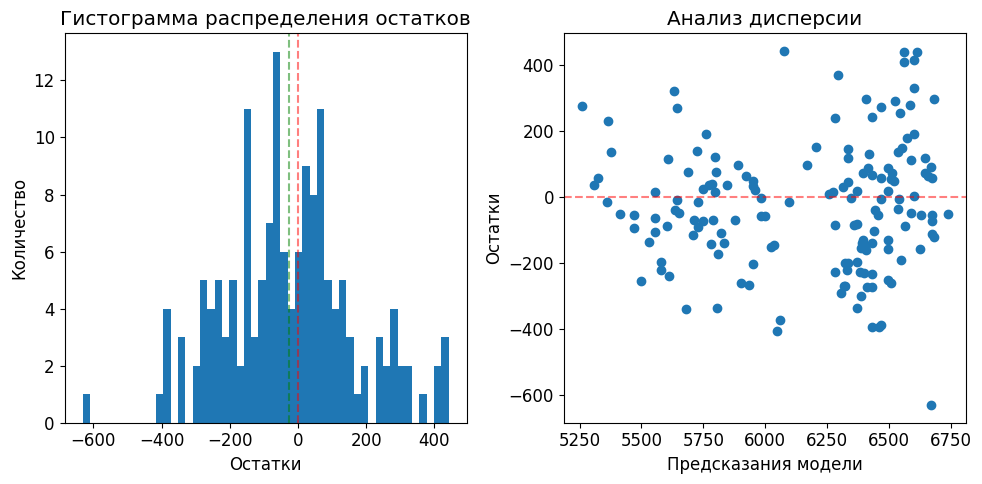

R2 на тестовой выборке: 0.815
MAE на тестовой выборке: 152.738
MSE на тестовой выборке: 37708.140
RMSE на тестовой выборке: 194.186

Доверительный интервал прогноза (95%):
Нижняя граница ошибки: -380.28 кг молока
Верхняя граница ошибки: 428.39 кг молока


(LinearRegression(),
 StandardScaler(),
 Index(['эке_кв', 'порода_Вис Бик Айдиал', 'порода_РефлешнСоверинг',
        'пастбище_Равнинное', 'пастбище_Холмистое', 'возраст_более_2_лет',
        'возраст_менее_2_лет', 'порода_отца_Айдиал', 'порода_отца_Соверин',
        'спо_кат_высокое', 'спо_кат_низкое'],
       dtype='object'))

In [59]:
numeric_features = ['эке_кв']

categorical_features = ['порода', 'пастбище', 'возраст', 'порода_отца', 'спо_кат']

target = 'удой'

run_model_lr(numeric_features, categorical_features, target, ferma_merged)

#### Вывод
- Гистограмма:
    * Гистограмма демонстрирует нормальное распределение с более выраженной симметричностью
    * Основная масса ошибок находится в диапазоне ±200 кг молока
    * Количество экстремальных выбросов (более ±400 кг) заметно уменьшилось
    * Пик распределения более узкий и высокий, что говорит о большей точности предсказаний
- Дисперсия:
    * Разброс остатков более равномерный по всему диапазону предсказаний
    * Основная масса точек сконцентрирована ближе к нулевой линии
    * Экстремальные отклонения встречаются реже
* R2 = 0.815 показывает значительное улучшение по сравнению с предыдущей моделью
* Добавление новых признаков и преобразования существующих позволили существенно повысить качество



#### Обучение третьей модели
Добавим признак 'имя_отца'

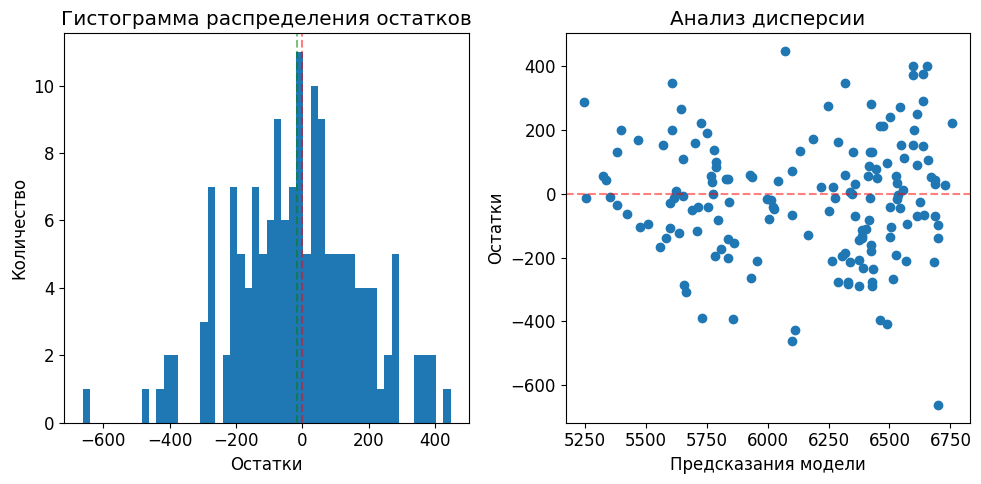

R2 на тестовой выборке: 0.822
MAE на тестовой выборке: 148.700
MSE на тестовой выборке: 36301.742
RMSE на тестовой выборке: 190.530

Доверительный интервал прогноза (95%):
Нижняя граница ошибки: -351.69 кг молока
Верхняя граница ошибки: 388.44 кг молока


In [60]:
numeric_features = ['эке_кв']

categorical_features = ['порода', 'пастбище', 'возраст', 'порода_отца', 'спо_кат', 'имя_отца']

target = 'удой'

model, scaler, encoder = run_model_lr(numeric_features, categorical_features, target, ferma_merged)

#### Вывод
* R2 = 0.822 показывает улучшение по сравнению с предыдущей моделью
* Добавление нового признака позволило повысить качество
* Эта модель фактически является лучшей

#### Прогноз удоя коров

In [61]:
mean_values = ferma_merged[['эке', 'протеин', 'спо']].mean()
mean_values = mean_values * 1.05

cow_buy_prepared = cow_buy.copy()

for feature in ['эке', 'протеин', 'спо']:
    cow_buy_prepared[feature] = mean_values[feature]

cow_buy_prepared['эке_кв'] = cow_buy_prepared['эке'] ** 2
cow_buy_prepared['спо_кат'] = cow_buy_prepared['спо'].apply(categorize_spo)


In [62]:
def make_prediction(model, scaler, encoder, numeric_features, categorical_features, df):
    features = numeric_features + categorical_features
    X_pred = df[features].copy()
    X_pred[numeric_features] = scaler.transform(X_pred[numeric_features])
    X_pred = pd.get_dummies(X_pred, drop_first=False)
    for col in encoder:
        if col not in X_pred.columns:
            X_pred[col] = 0
    X_pred = X_pred[encoder]
    predictions = model.predict(X_pred)
    return predictions

In [63]:
cow_buy_prepared['удой'] = make_prediction(model, scaler, encoder, numeric_features, categorical_features, cow_buy_prepared)

In [67]:
cow_buy_prepared.sort_values(by='удой', ascending=False)

порода   пастбище порода_отца  имя_отца  жирность  белок  \
11  РефлешнСоверинг  Равнинное     Соверин  Геркулес      3.73   3.07   
0    Вис Бик Айдиал  Холмистое      Айдиал  Геркулес      3.58   3.08   
6    Вис Бик Айдиал  Холмистое      Айдиал  Геркулес      3.58   3.08   
12   Вис Бик Айдиал  Холмистое      Айдиал  Геркулес      3.68   3.05   
3   РефлешнСоверинг  Холмистое      Айдиал    Буйный      3.40   3.06   
15  РефлешнСоверинг  Холмистое      Айдиал    Буйный      3.40   3.06   
7    Вис Бик Айдиал  Равнинное     Соверин    Буйный      3.57   3.08   
18   Вис Бик Айдиал  Равнинное     Соверин    Буйный      3.34   3.07   
19  РефлешнСоверинг  Равнинное      Айдиал    Буйный      3.64   3.07   
4   РефлешнСоверинг  Равнинное      Айдиал    Буйный      3.64   3.07   
17  РефлешнСоверинг  Равнинное     Соверин  Геркулес      3.77   3.05   
5   РефлешнСоверинг  Равнинное     Соверин  Геркулес      3.63   3.05   
9   РефлешнСоверинг  Холмистое      Айдиал    Буйный      3.40   3.08   
1    Вис Бик Айдиал  Равнинное     Соверин    Буйный      3.54   3.08   
16   Вис Бик Айдиал  Холмистое     Соверин  Соловчик      3.73   3.08   
10   Вис Бик Айдиал  Холмистое     Соверин  Соловчик      3.73   3.06   
2   РефлешнСоверинг  Равнинное     Соверин     Барин      3.59   3.07   
8   РефлешнСоверинг  Равнинное     Соверин     Барин      3.59   3.07   
14  РефлешнСоверинг  Равнинное     Соверин     Барин      3.59   3.07   
13   Вис Бик Айдиал  Холмистое     Соверин     Барин      3.42   3.08   

        возраст         гибрид   эке  протеин  спо  эке_кв  спо_кат     удой  
11  более_2_лет  чистопородная 15.28 2,019.95 0.96  233.36  высокое 6,600.33  
0   более_2_лет  чистопородная 15.28 2,019.95 0.96  233.36  высокое 6,596.71  
6   более_2_лет  чистопородная 15.28 2,019.95 0.96  233.36  высокое 6,596.71  
12  более_2_лет  чистопородная 15.28 2,019.95 0.96  233.36  высокое 6,596.71  
3   более_2_лет         гибрид 15.28 2,019.95 0.96  233.36  высокое 6,579.58  
15  более_2_лет         гибрид 15.28 2,019.95 0.96  233.36  высокое 6,579.58  
7   более_2_лет         гибрид 15.28 2,019.95 0.96  233.36  высокое 6,557.34  
18  более_2_лет         гибрид 15.28 2,019.95 0.96  233.36  высокое 6,557.34  
19  более_2_лет         гибрид 15.28 2,019.95 0.96  233.36  высокое 6,524.10  
4   более_2_лет         гибрид 15.28 2,019.95 0.96  233.36  высокое 6,524.10  
17  менее_2_лет  чистопородная 15.28 2,019.95 0.96  233.36  высокое 6,400.17  
5   менее_2_лет  чистопородная 15.28 2,019.95 0.96  233.36  высокое 6,400.17  
9   менее_2_лет         гибрид 15.28 2,019.95 0.96  233.36  высокое 6,379.41  
1   менее_2_лет         гибрид 15.28 2,019.95 0.96  233.36  высокое 6,357.17  
16  более_2_лет         гибрид 15.28 2,019.95 0.96  233.36  высокое 6,355.42  
10  более_2_лет         гибрид 15.28 2,019.95 0.96  233.36  высокое 6,355.42  
2   более_2_лет  чистопородная 15.28 2,019.95 0.96  233.36  высокое 6,272.77  
8   более_2_лет  чистопородная 15.28 2,019.95 0.96  233.36  высокое 6,272.77  
14  более_2_лет  чистопородная 15.28 2,019.95 0.96  233.36  высокое 6,272.77  
13  менее_2_лет         гибрид 15.28 2,019.95 0.96  233.36  высокое 6,115.15

## Обучение модели логистической регрессии

## Итоговые выводы